Pares encontrados: 34


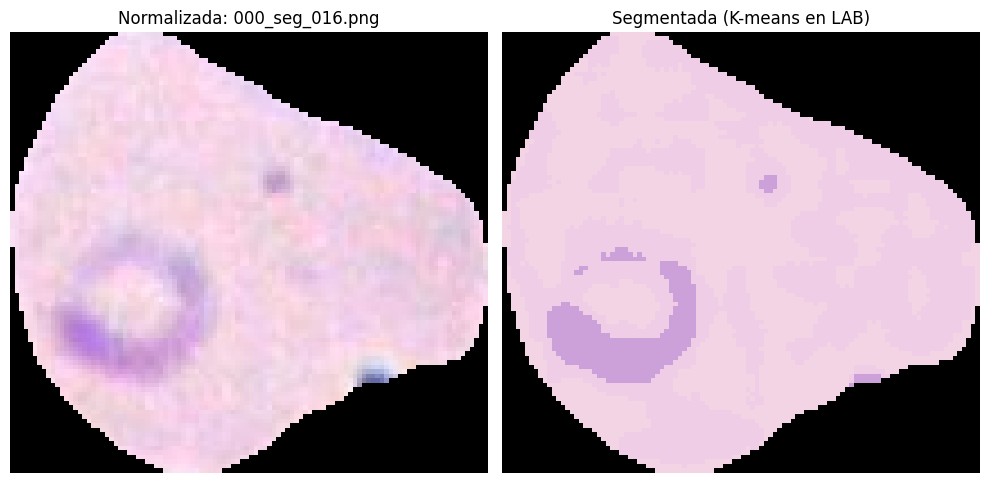

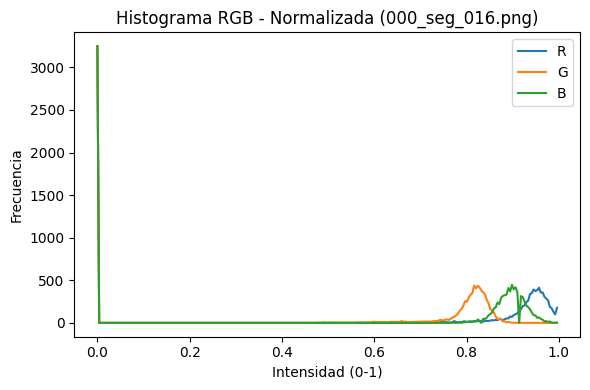

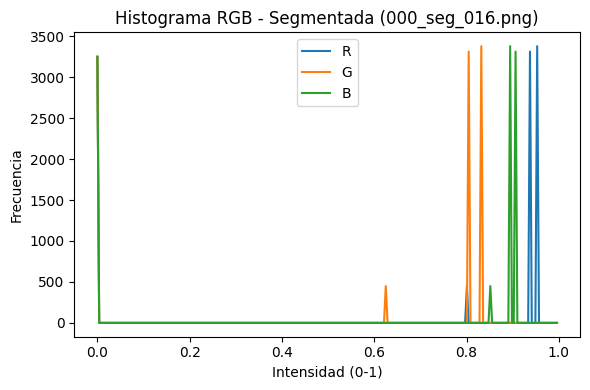

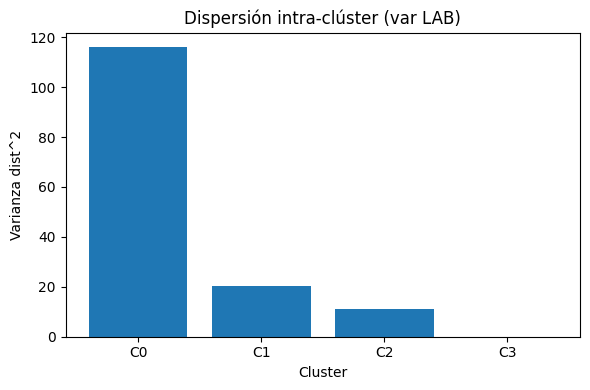

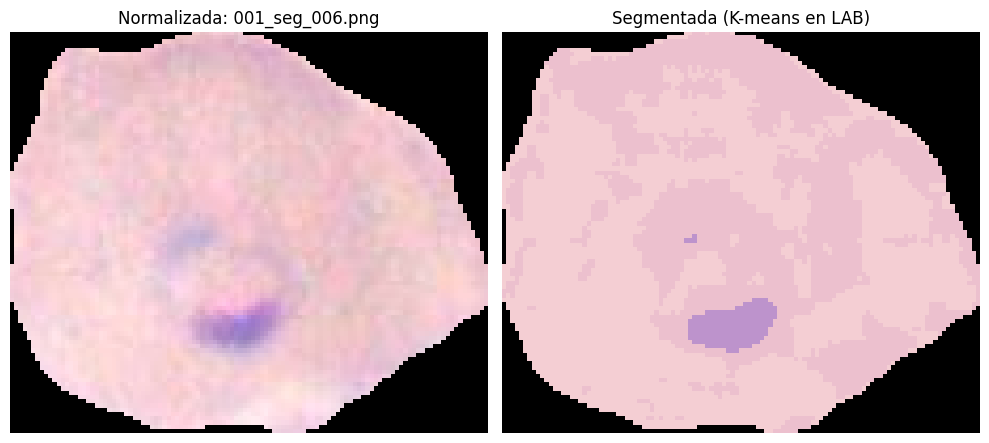

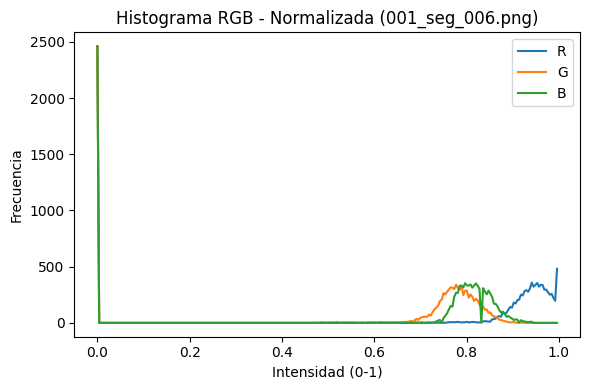

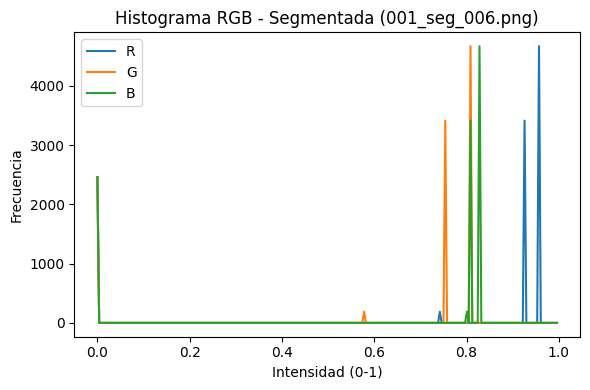

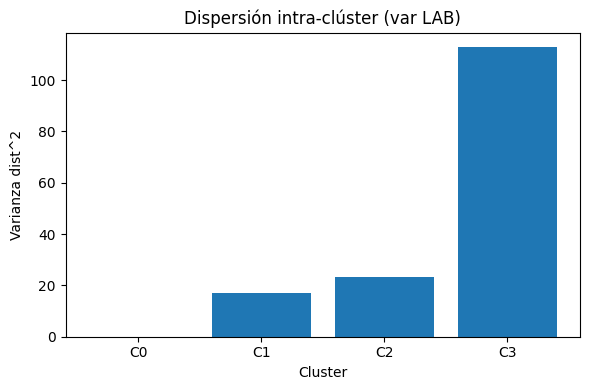

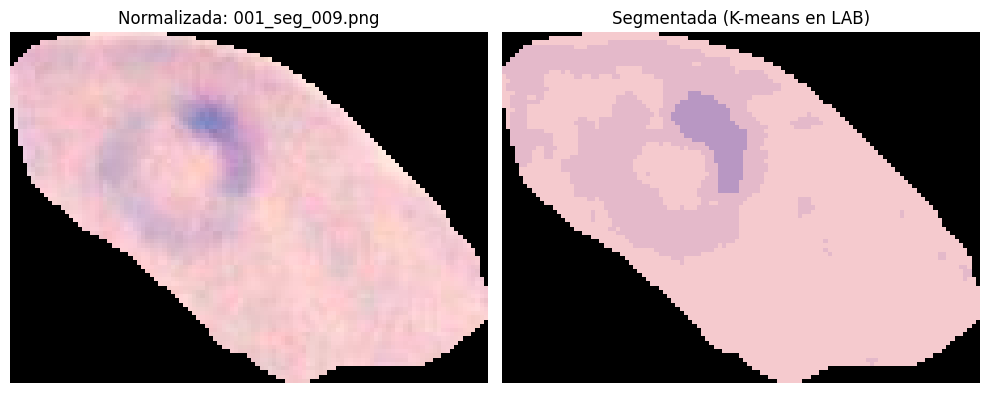

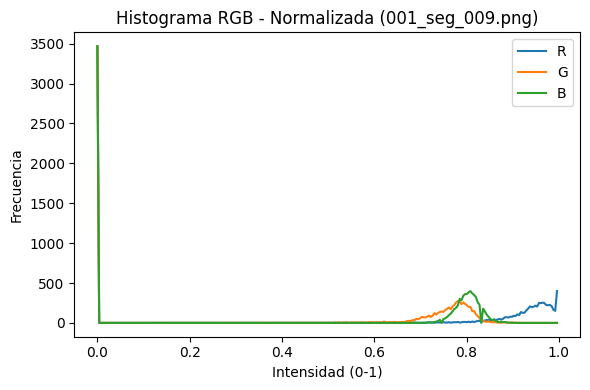

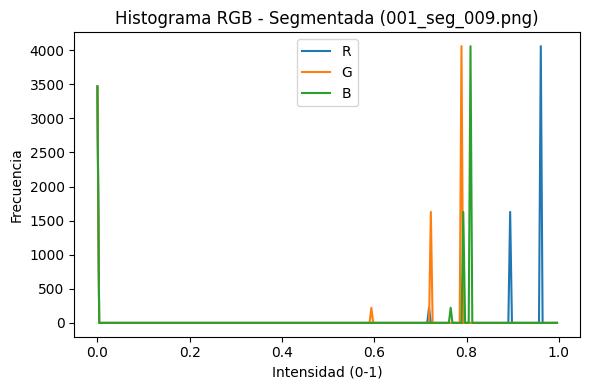

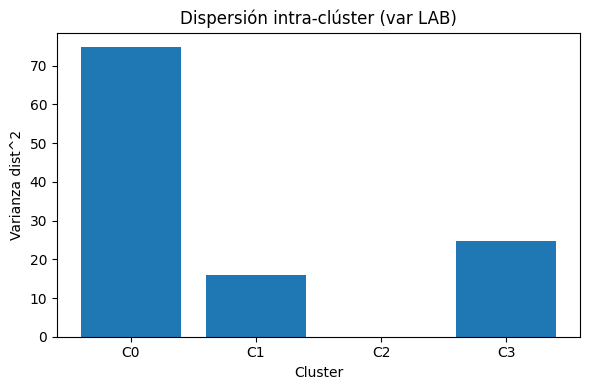

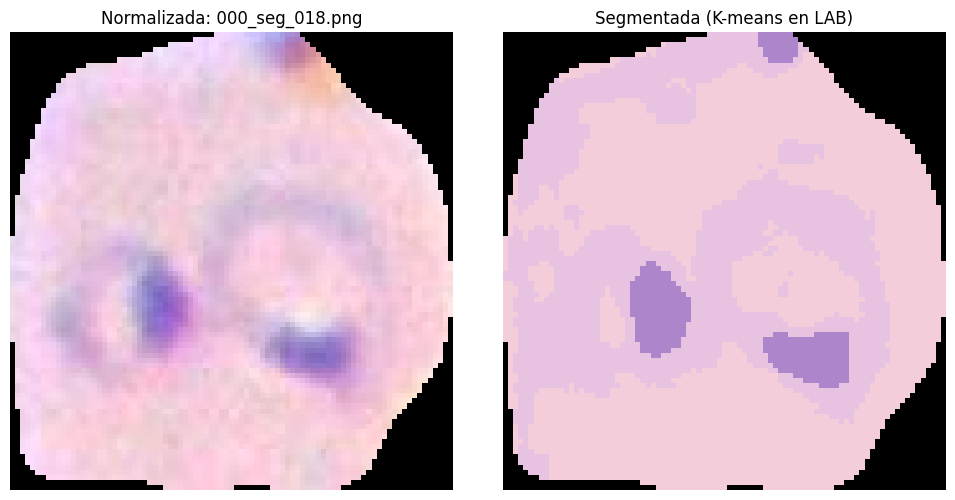

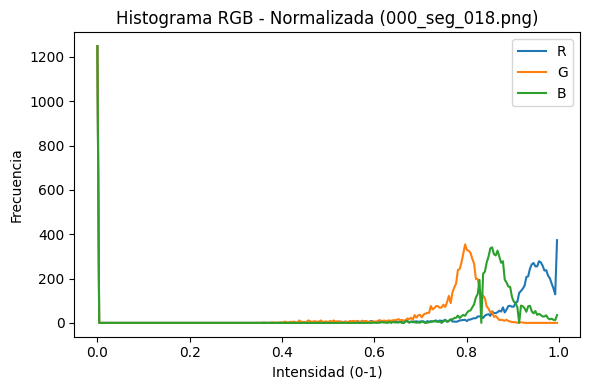

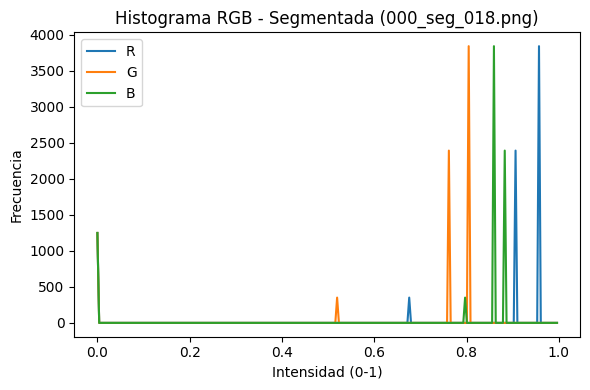

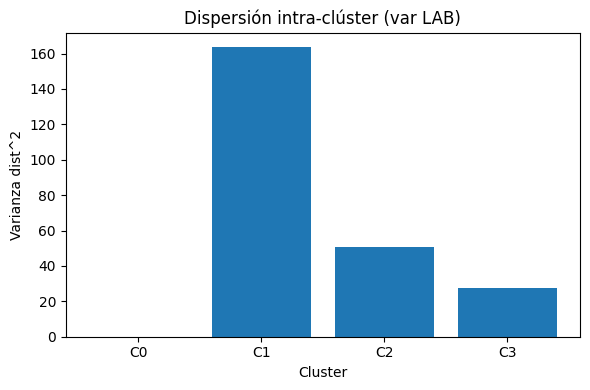

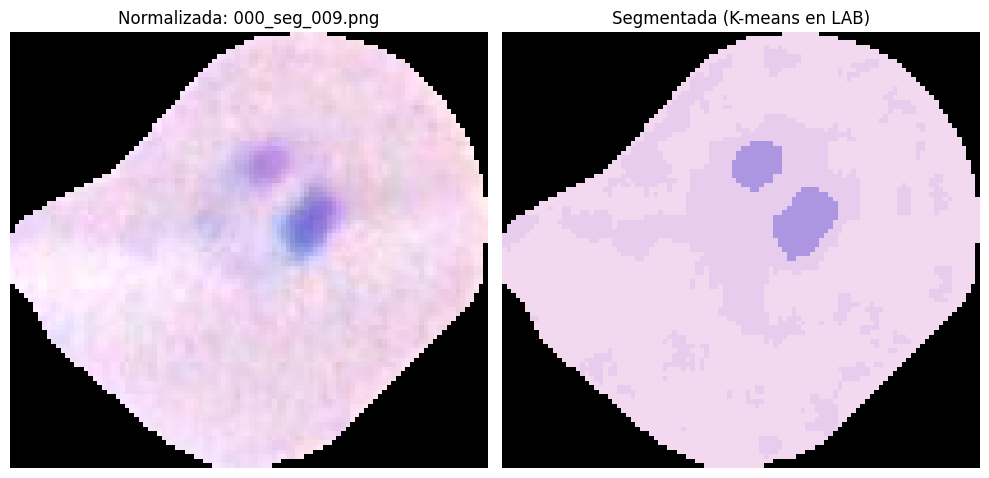

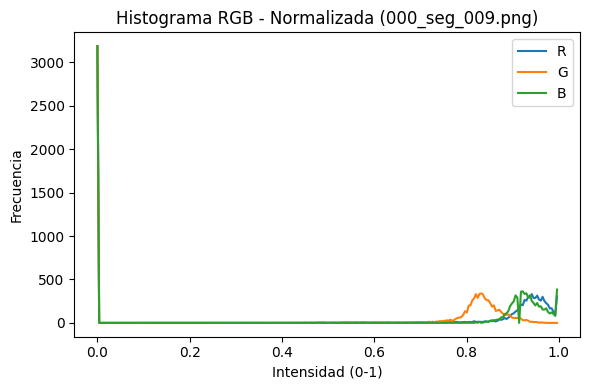

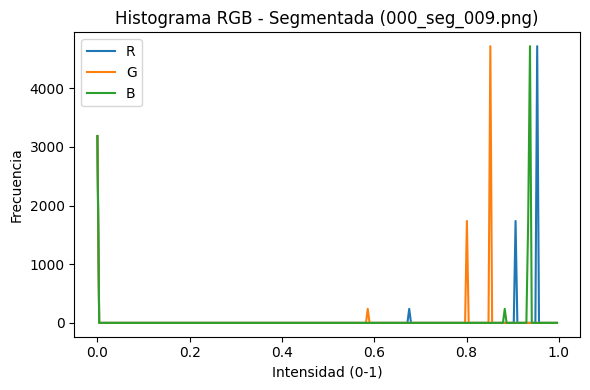

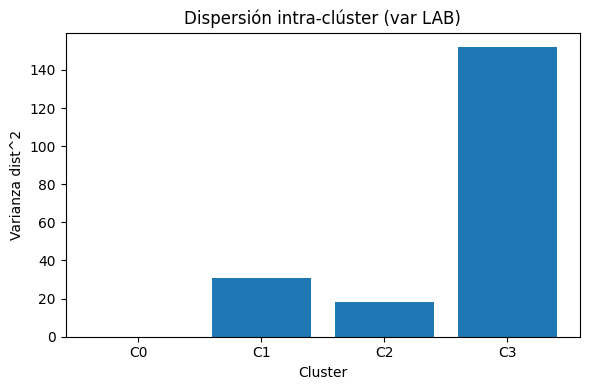

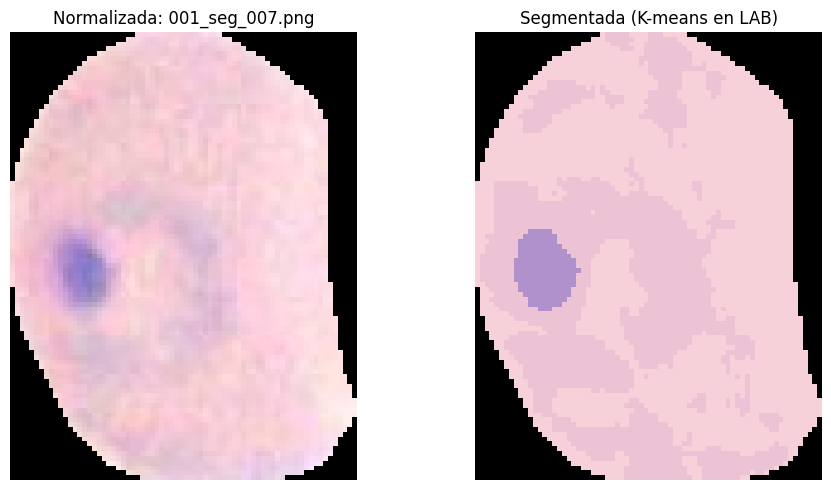

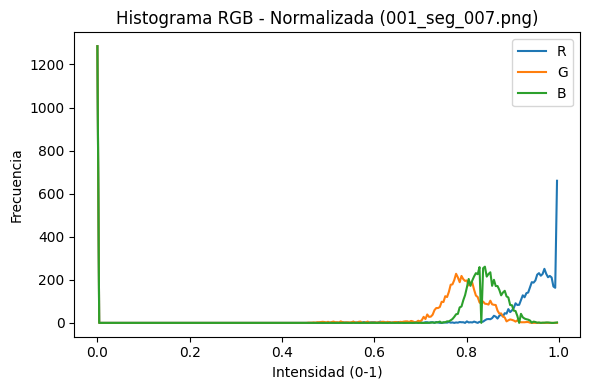

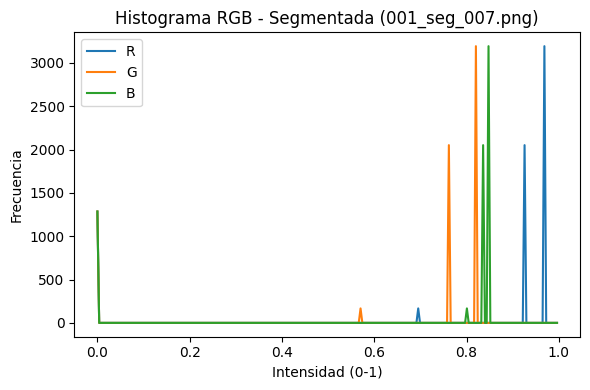

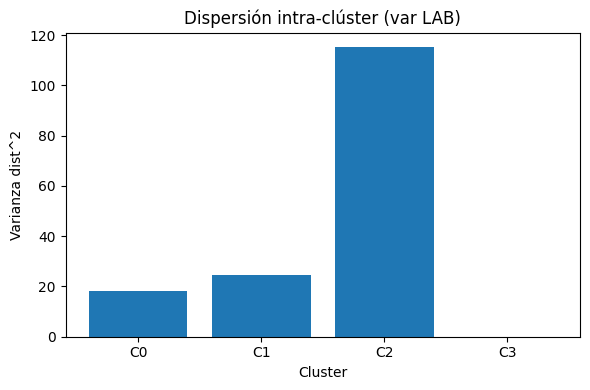

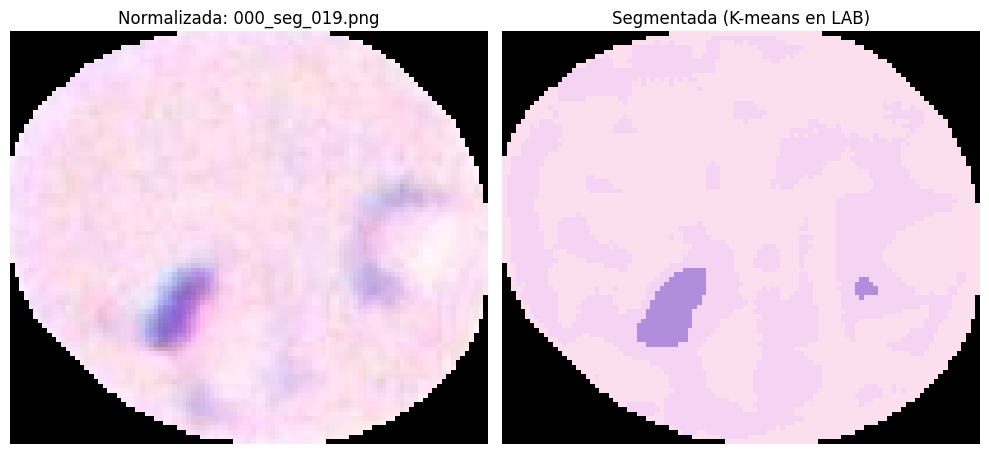

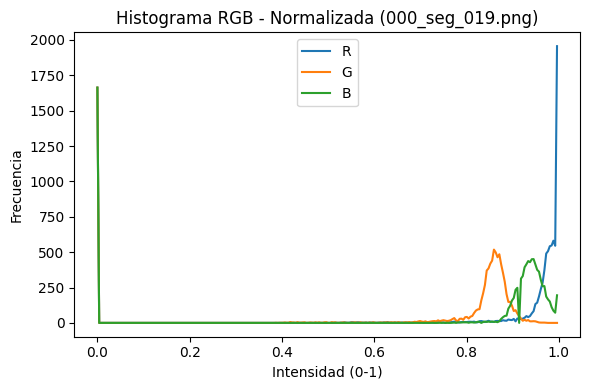

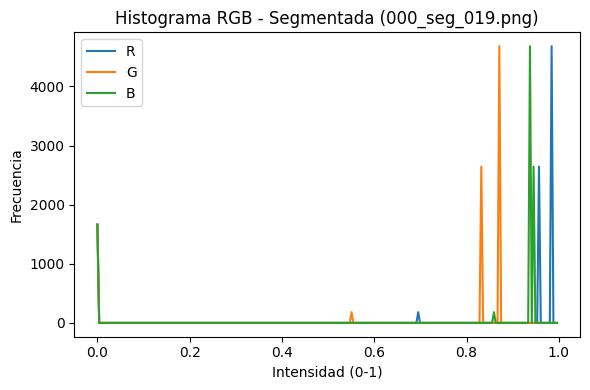

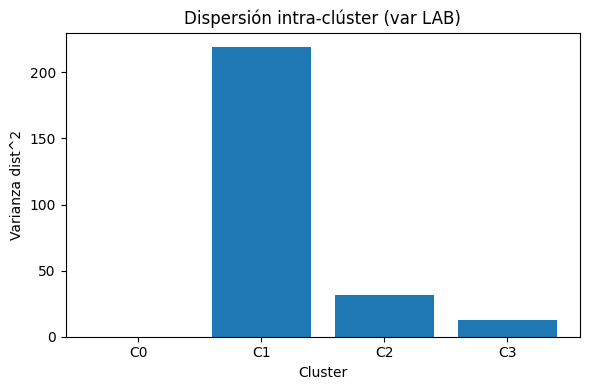

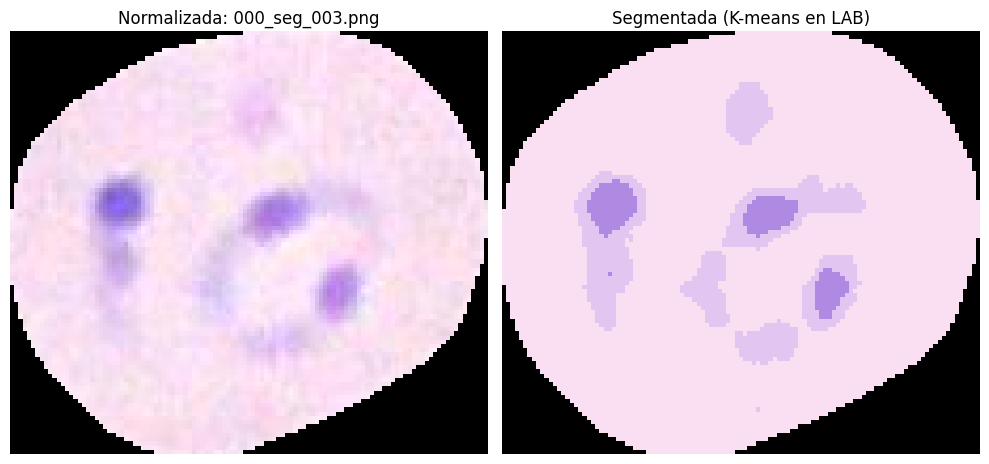

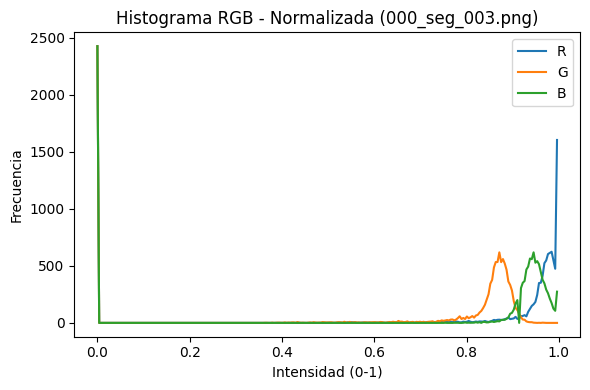

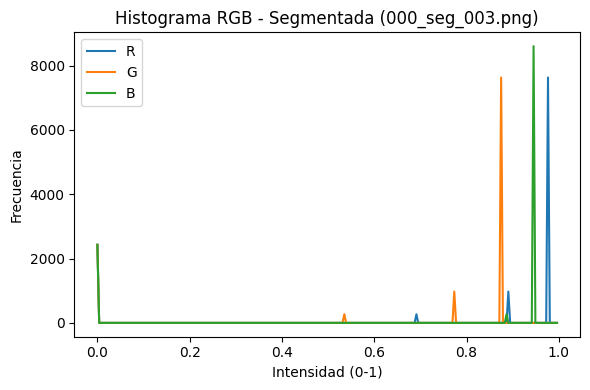

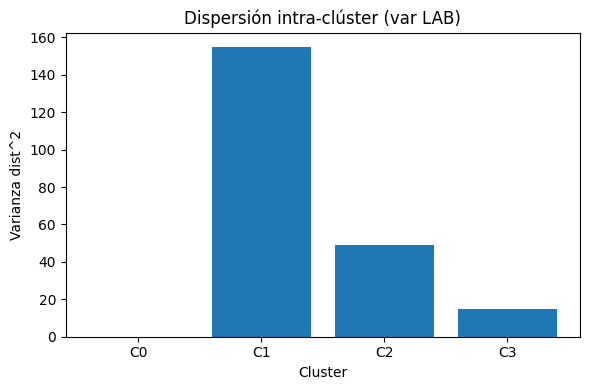

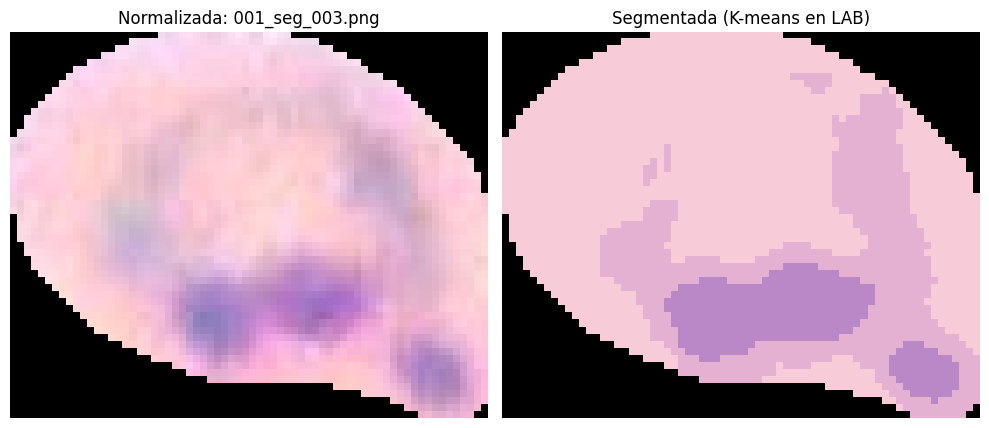

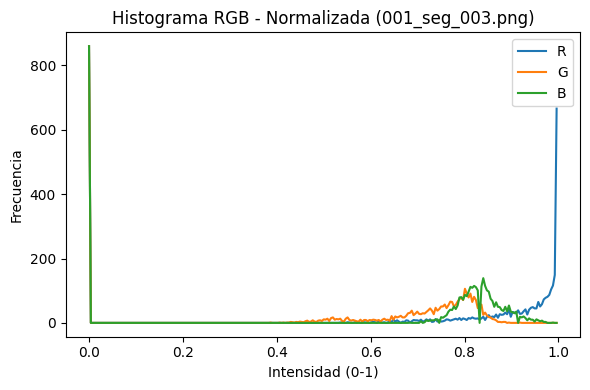

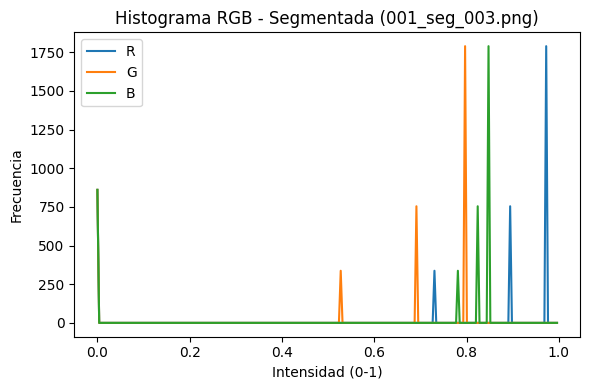

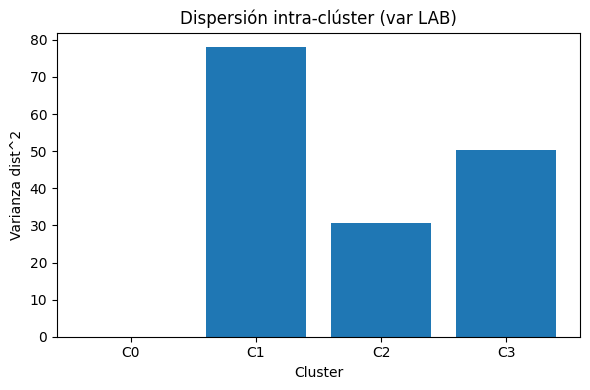

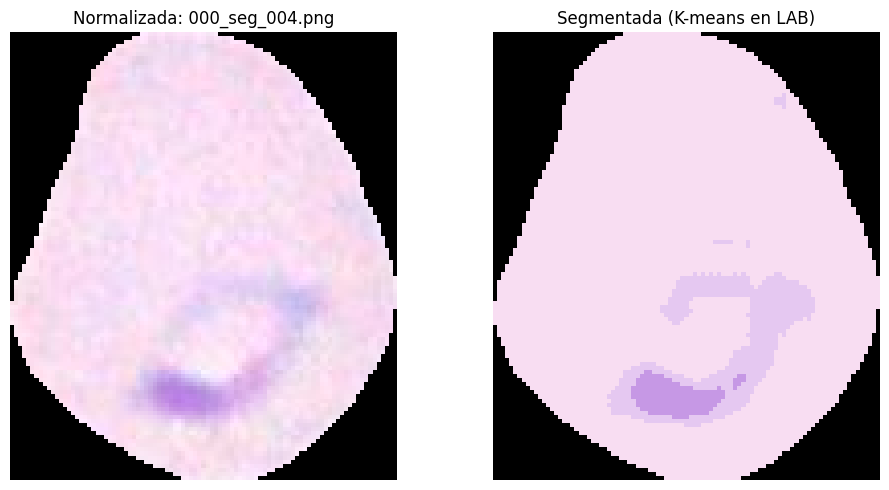

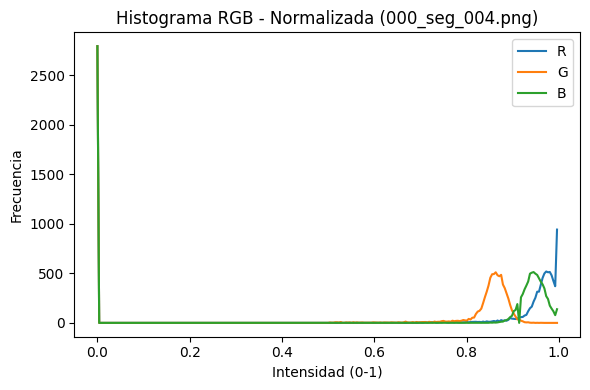

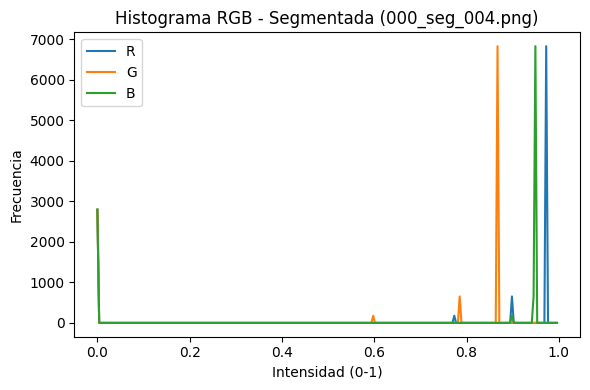

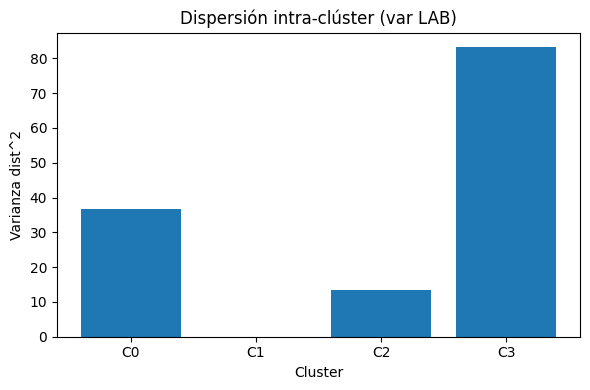

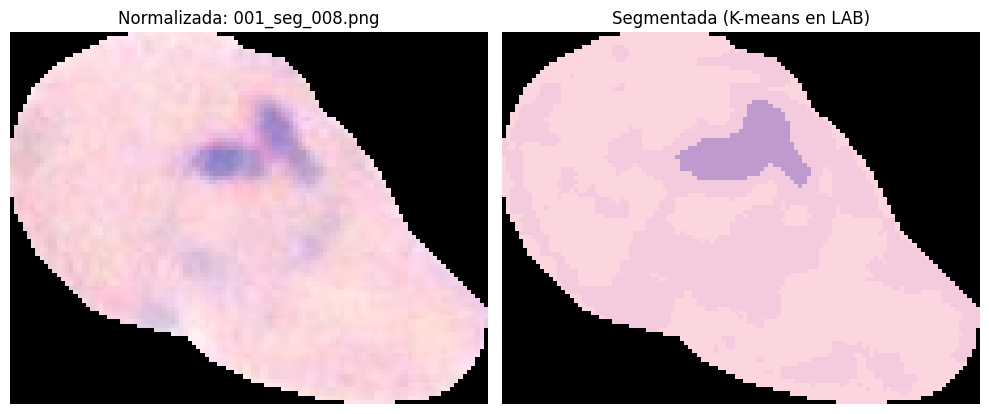

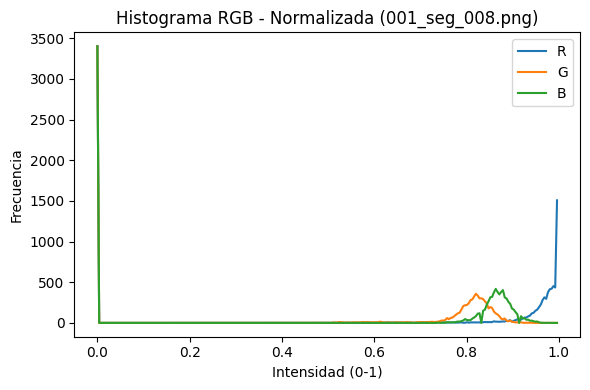

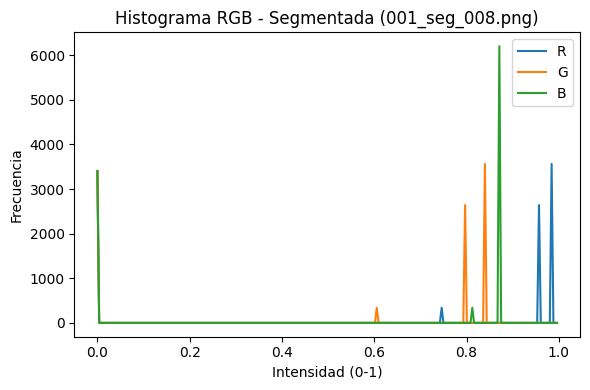

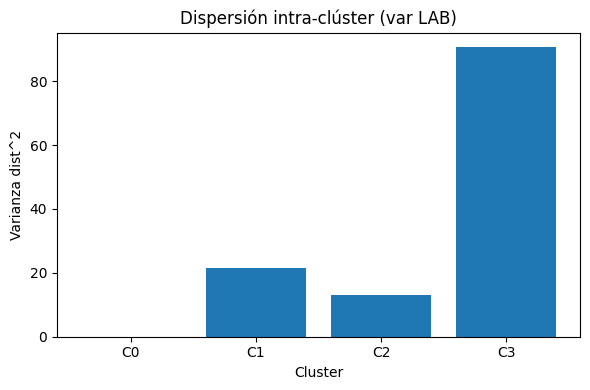

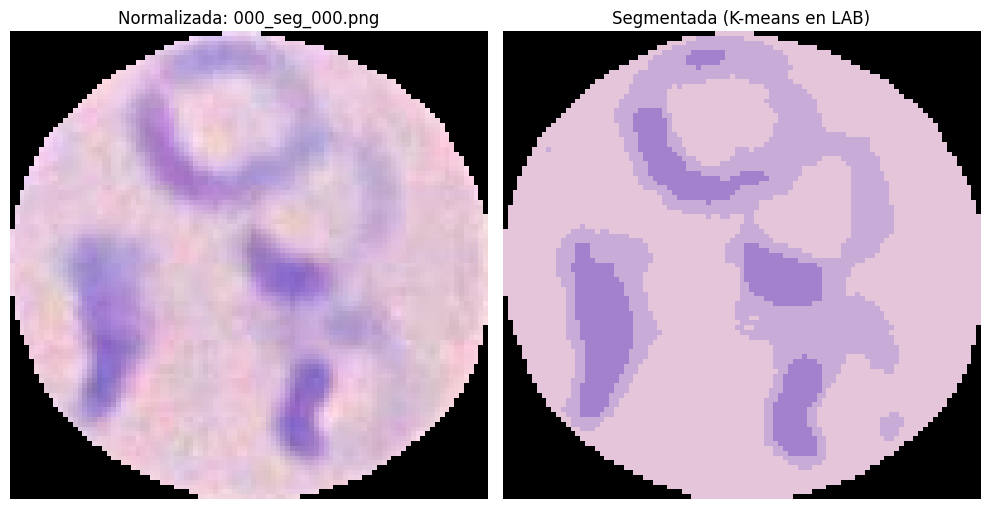

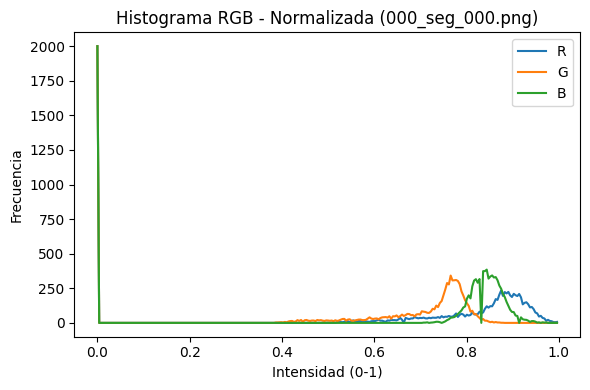

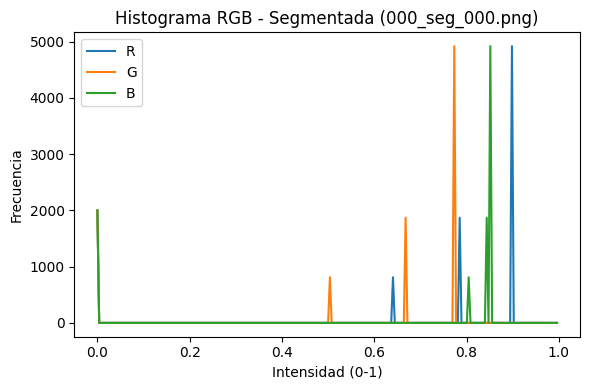

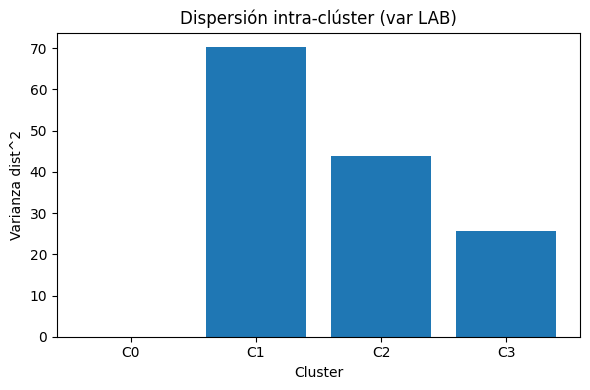

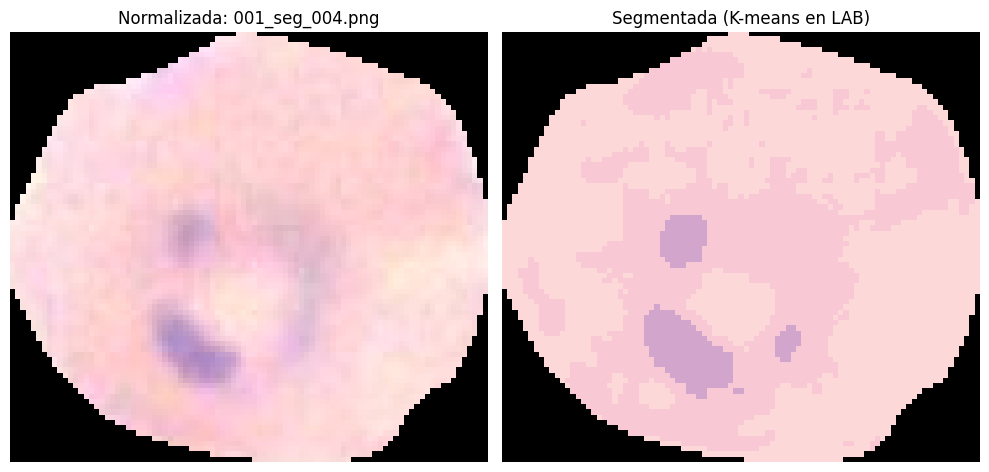

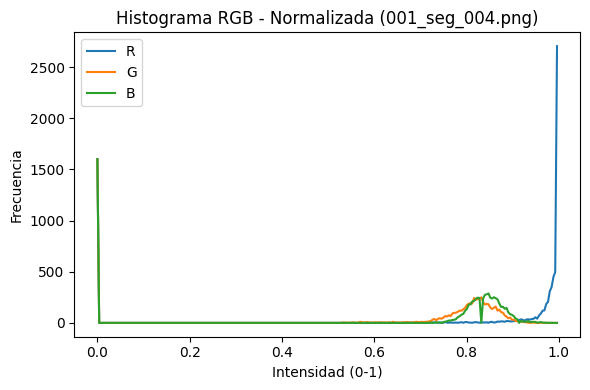

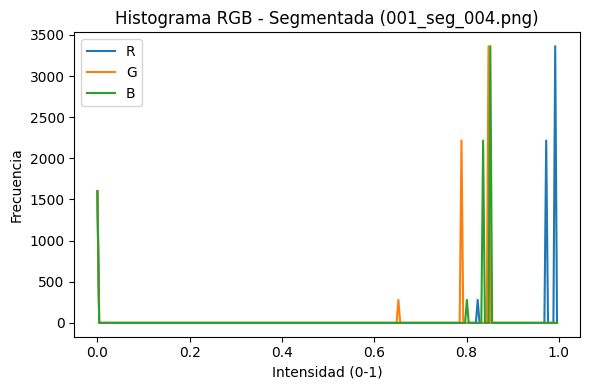

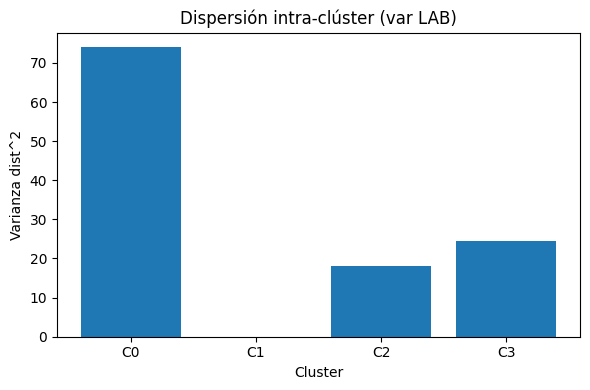

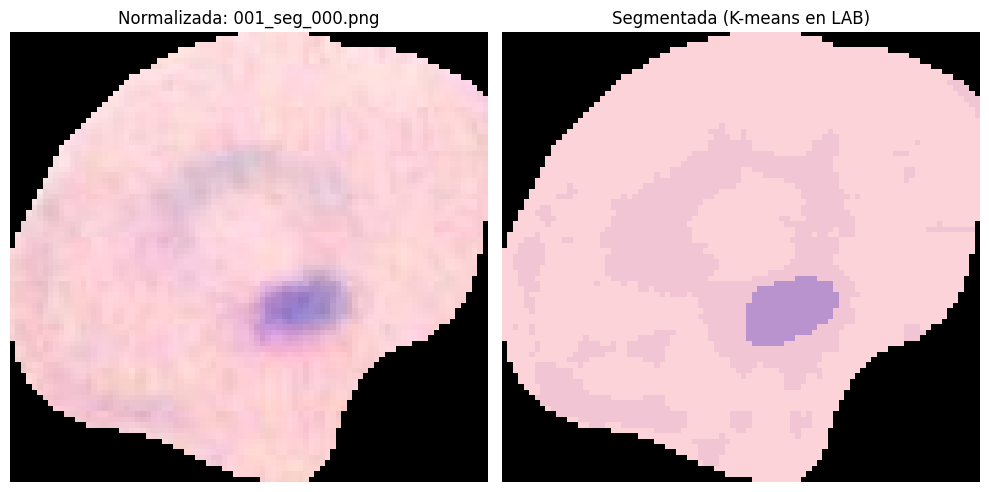

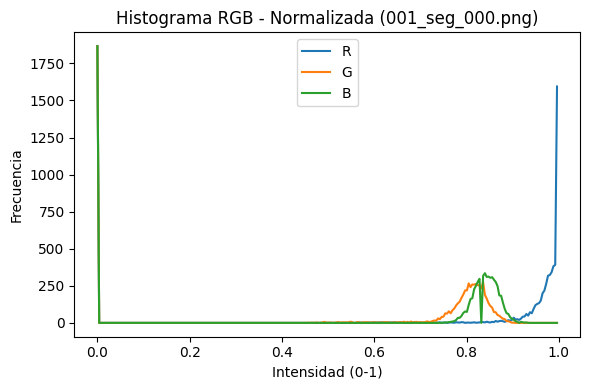

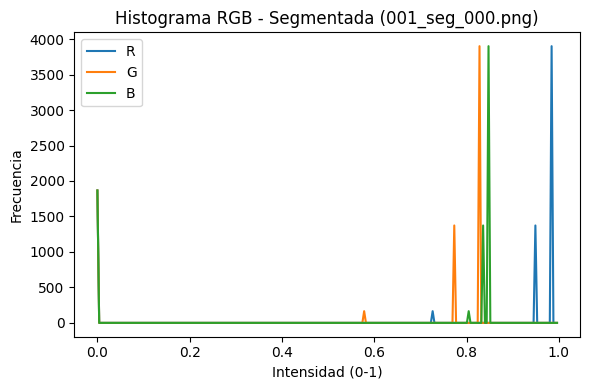

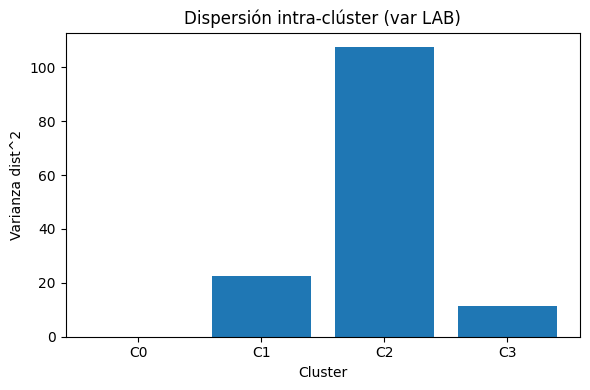

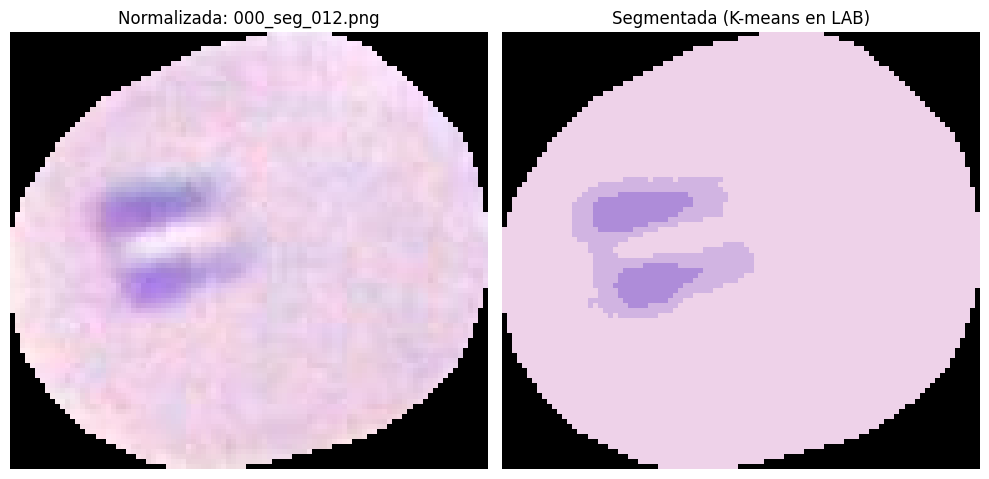

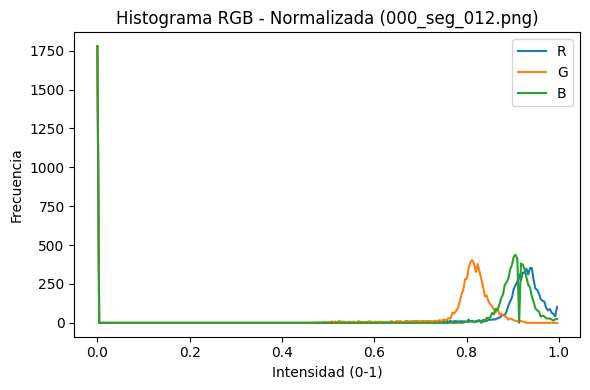

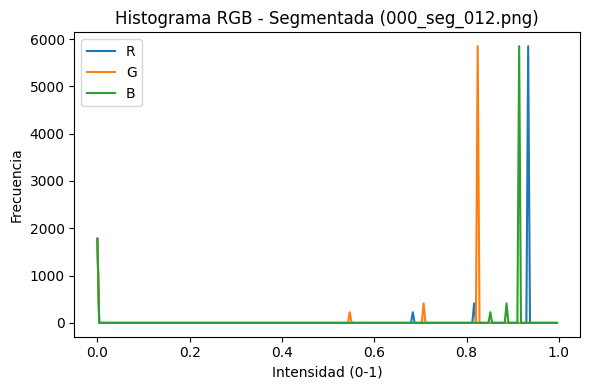

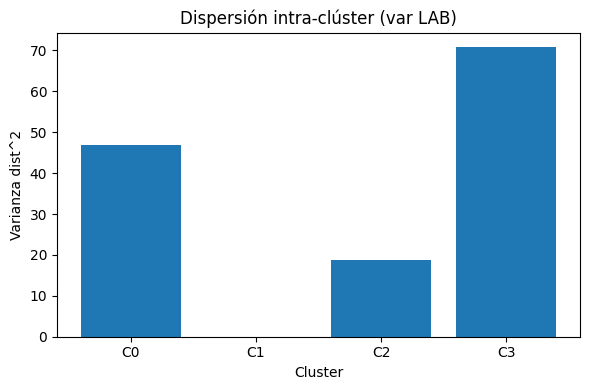

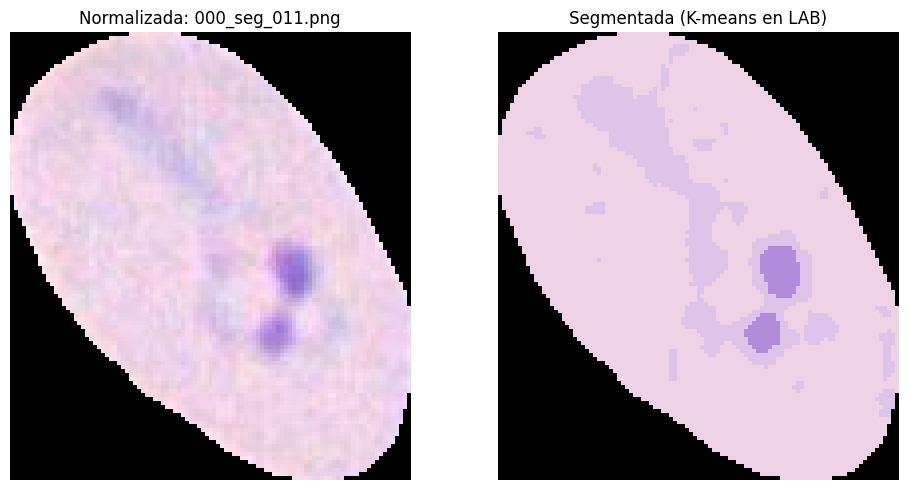

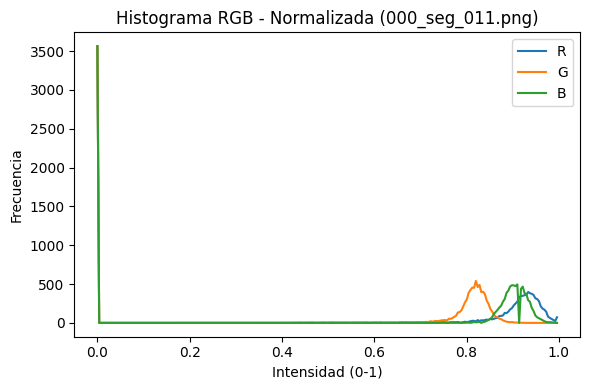

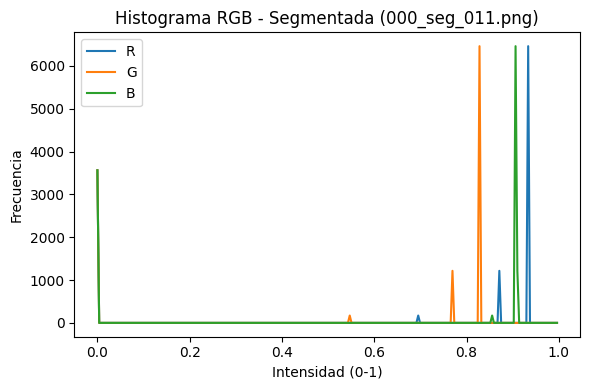

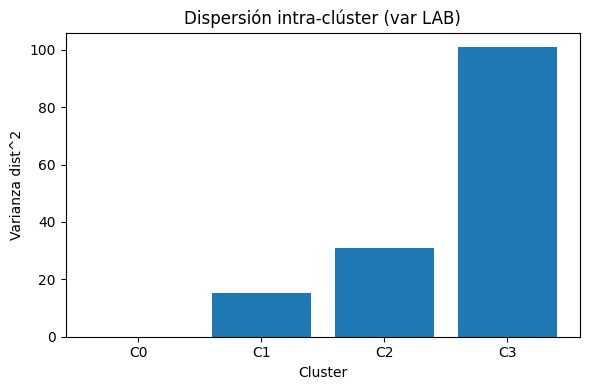

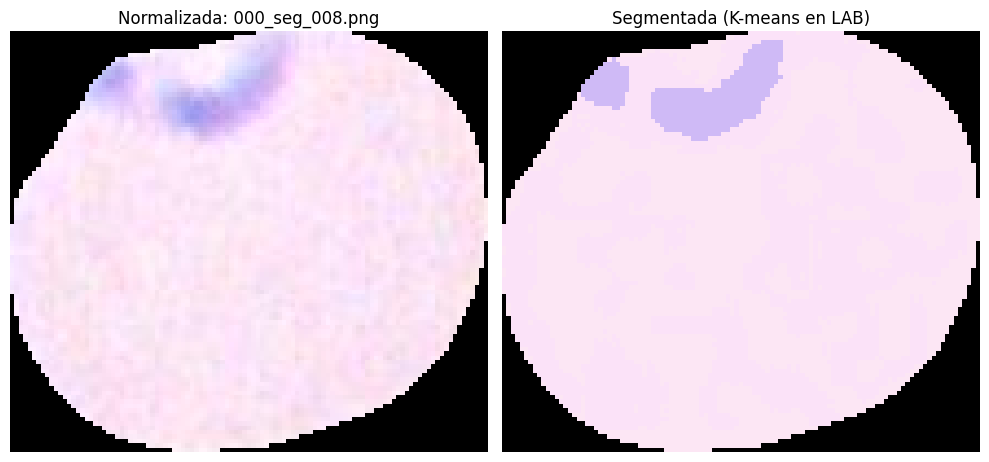

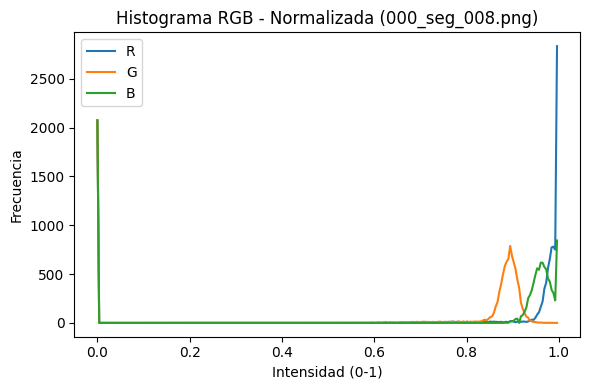

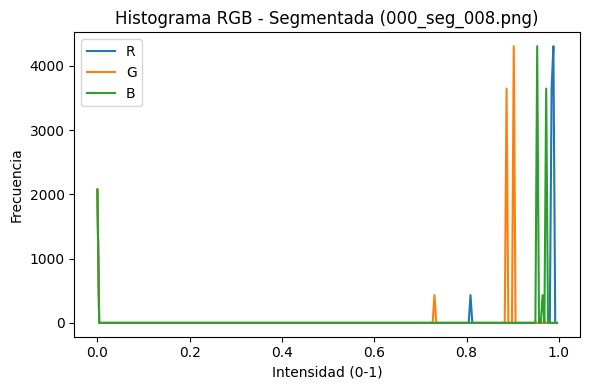

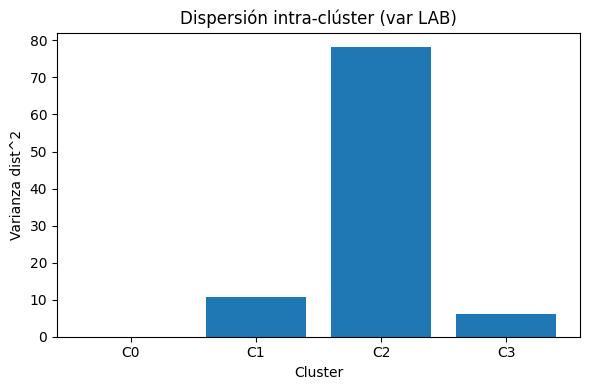

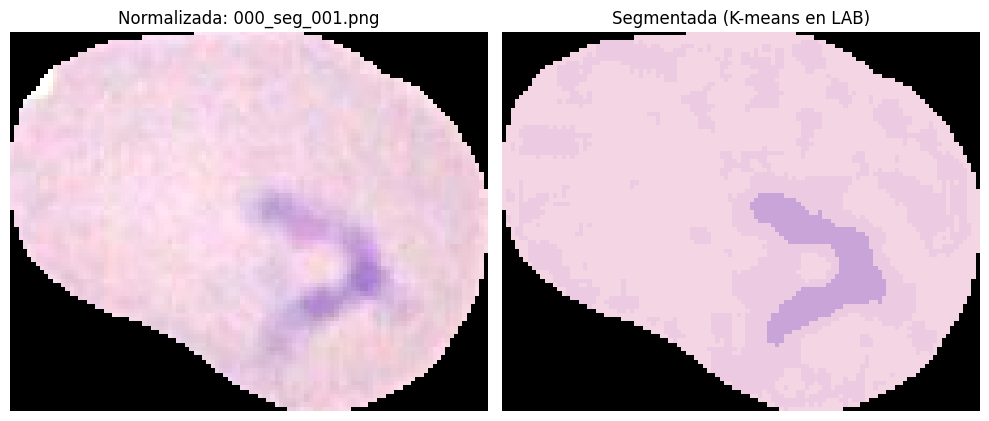

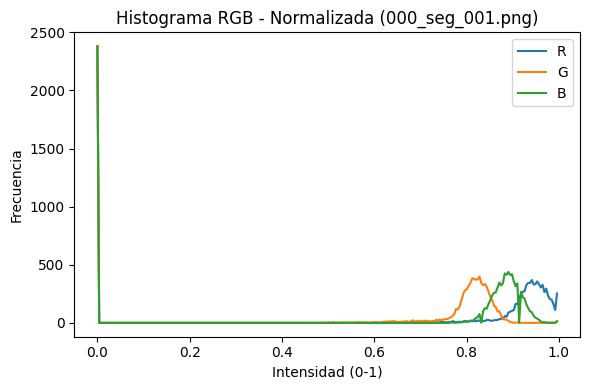

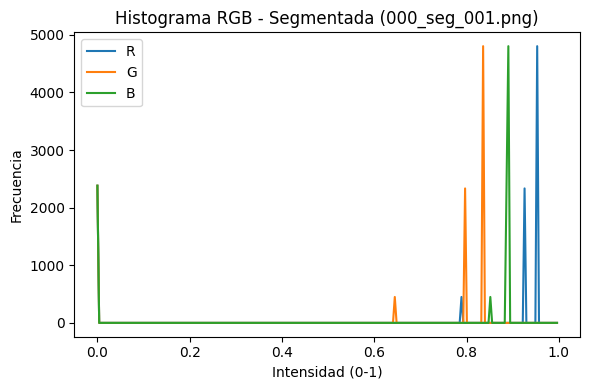

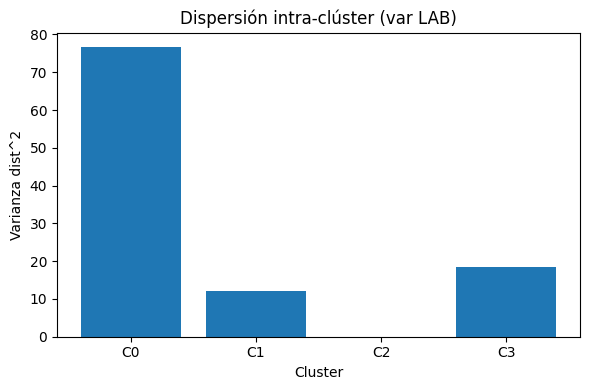

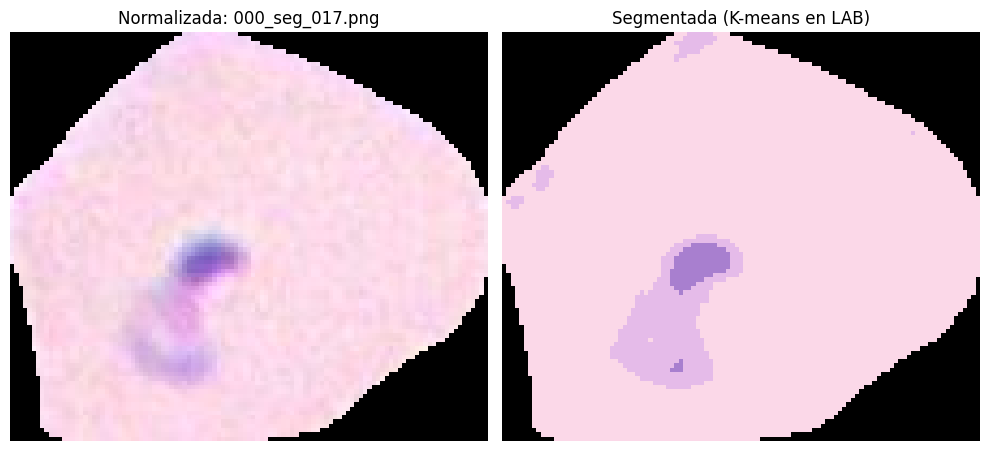

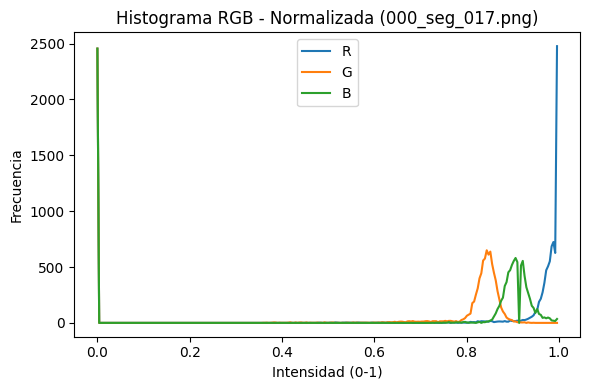

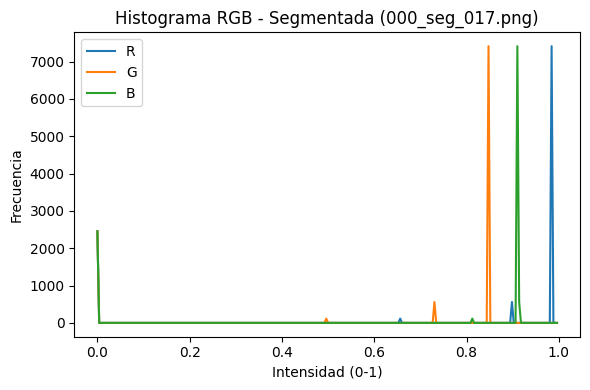

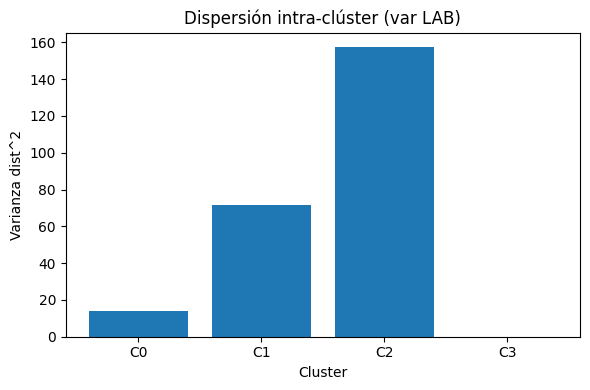

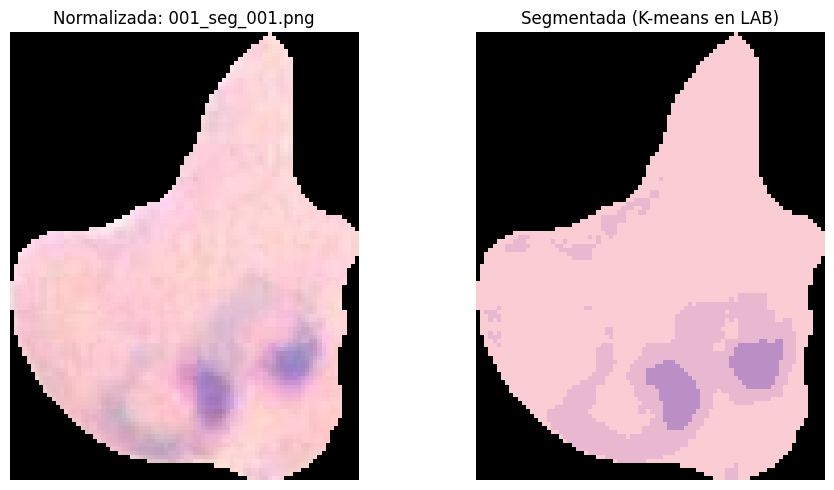

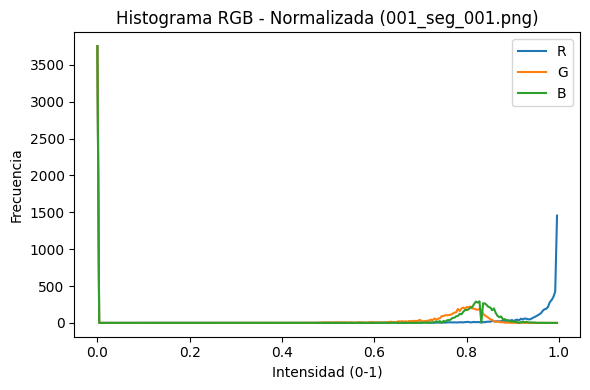

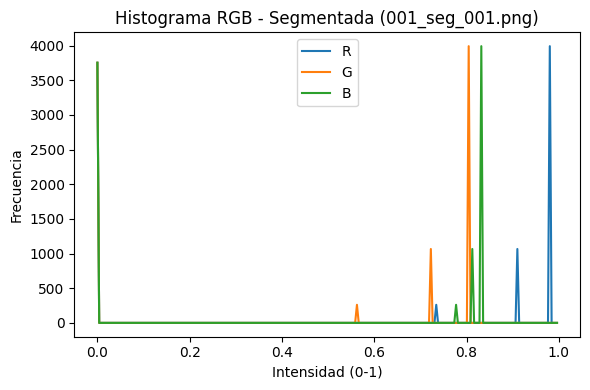

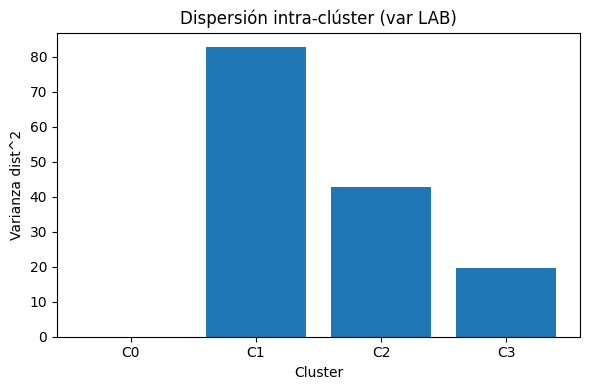

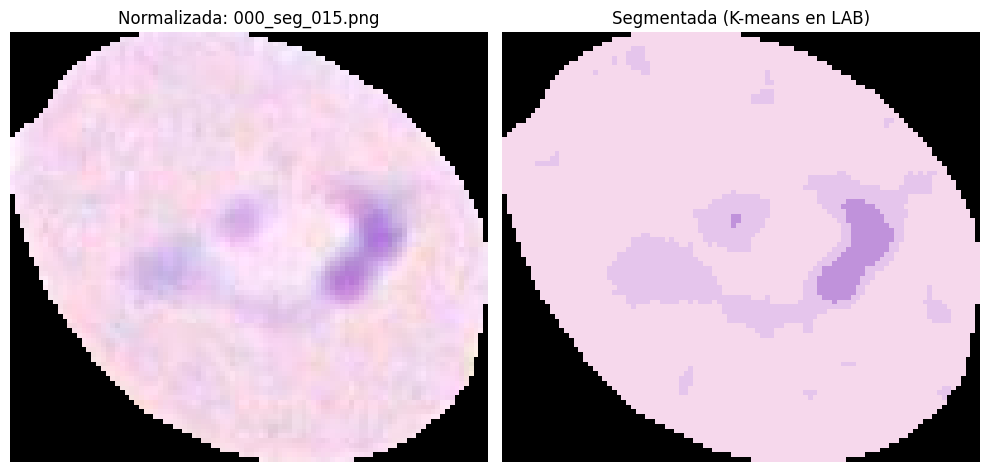

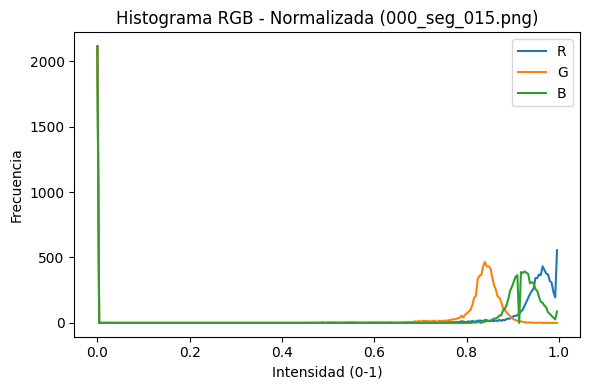

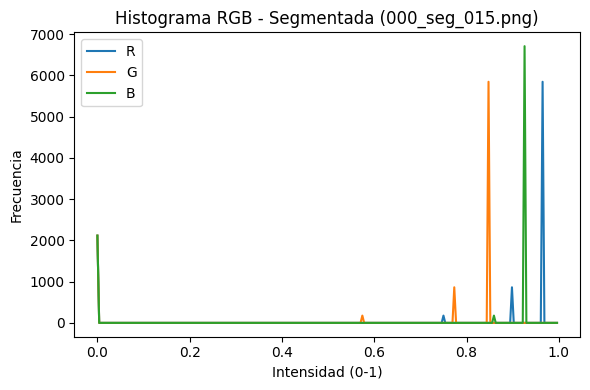

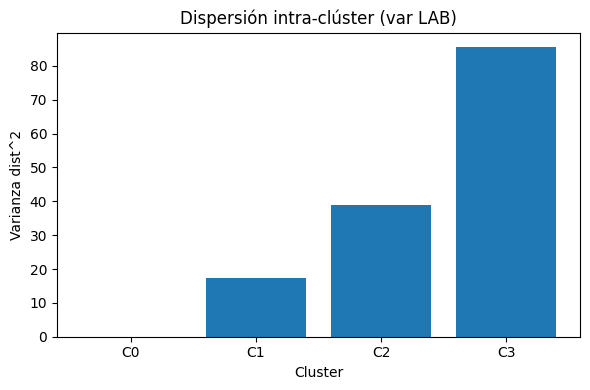

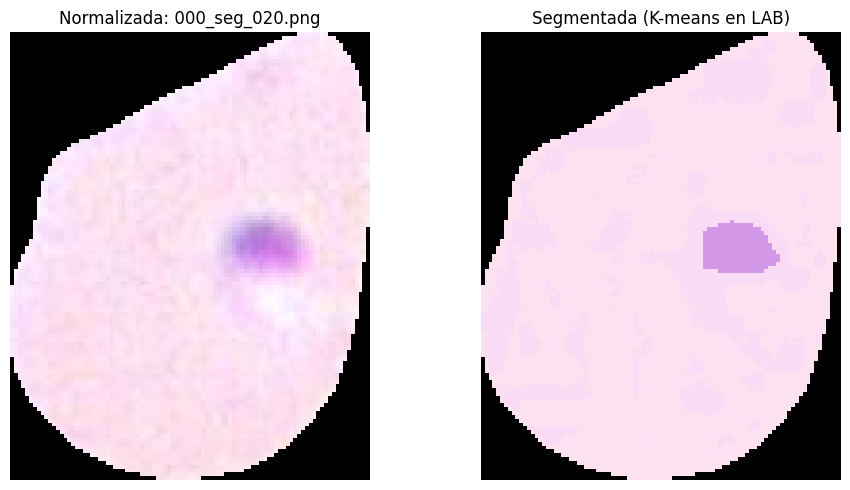

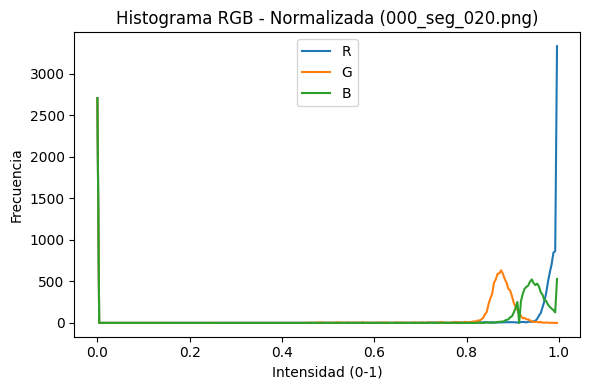

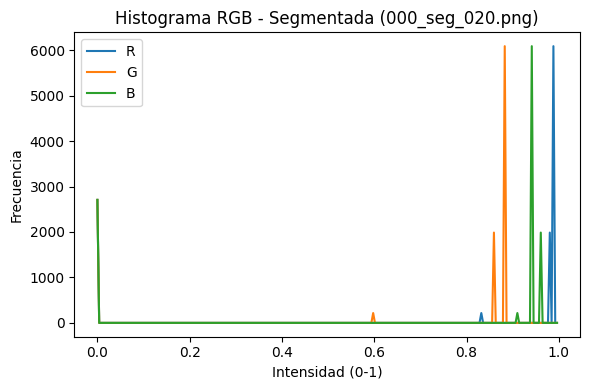

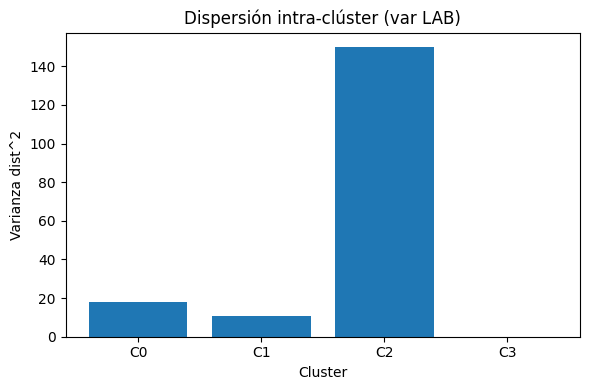

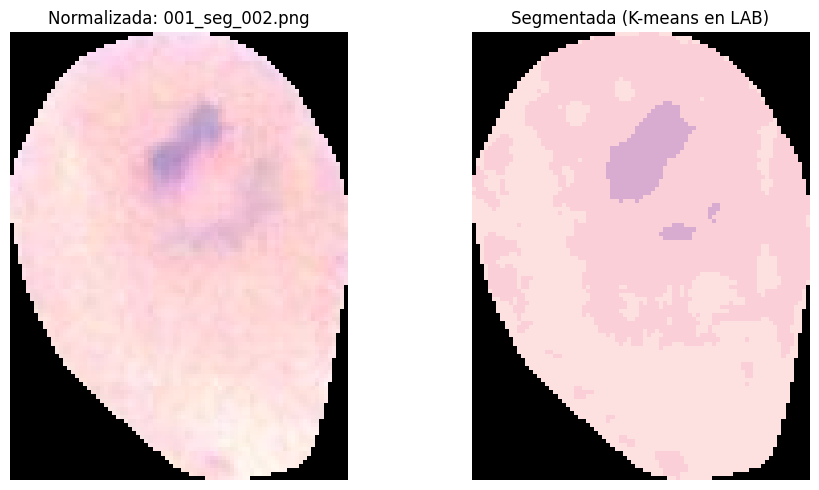

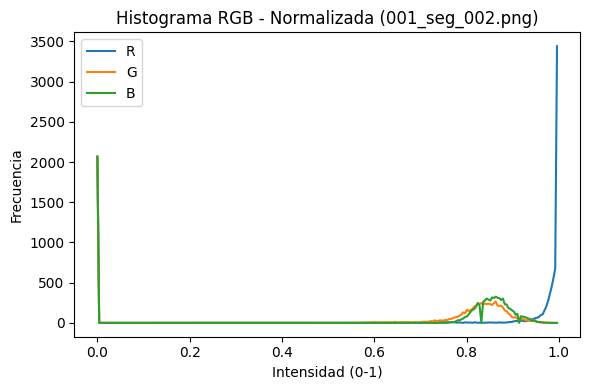

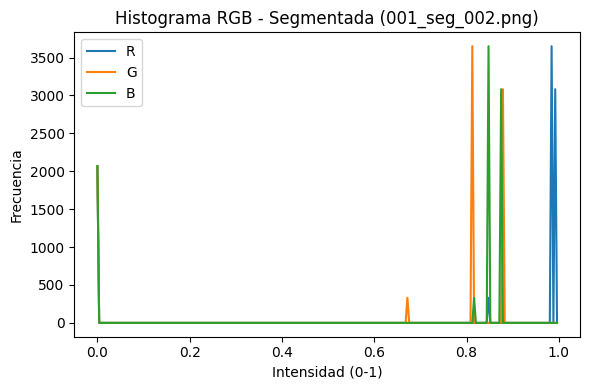

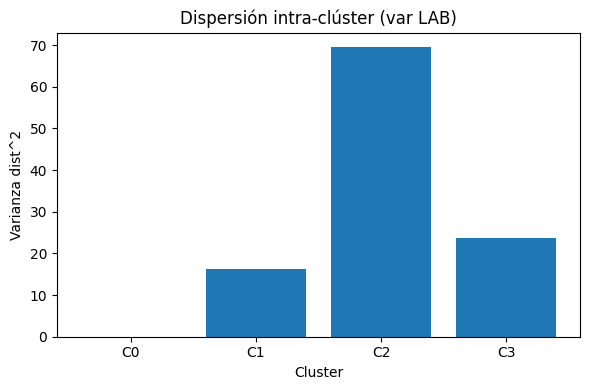

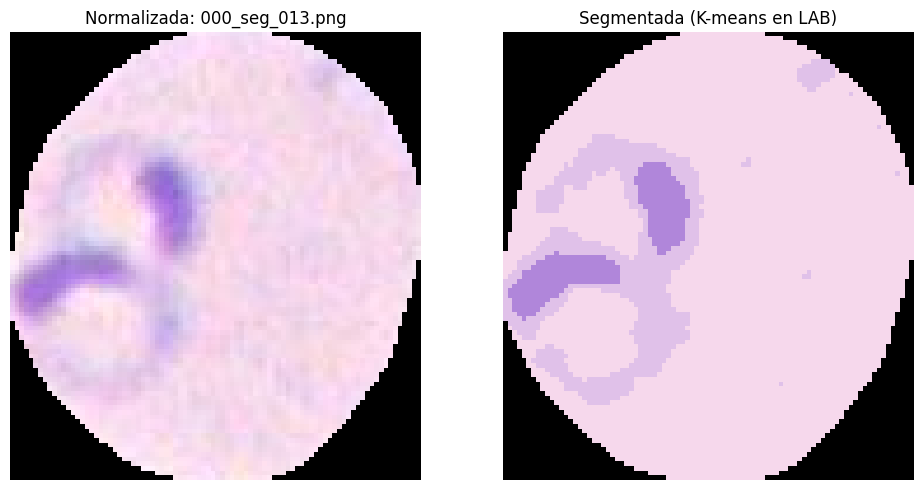

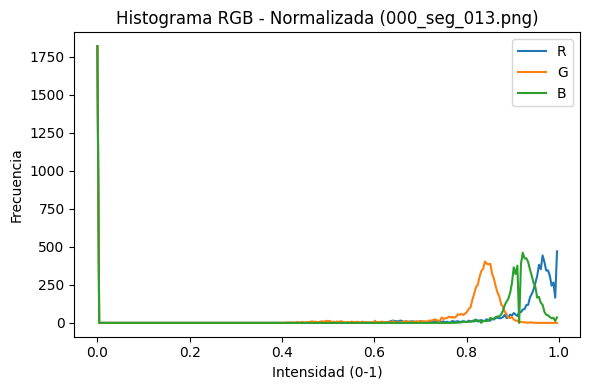

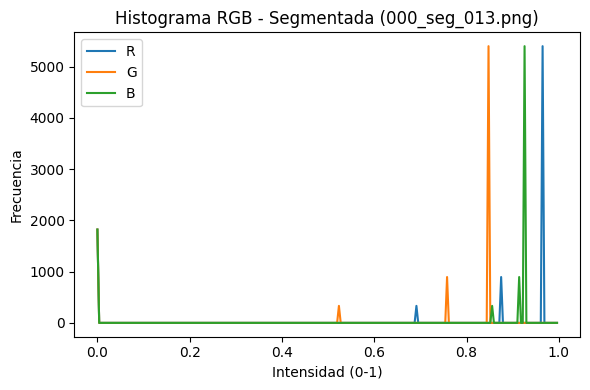

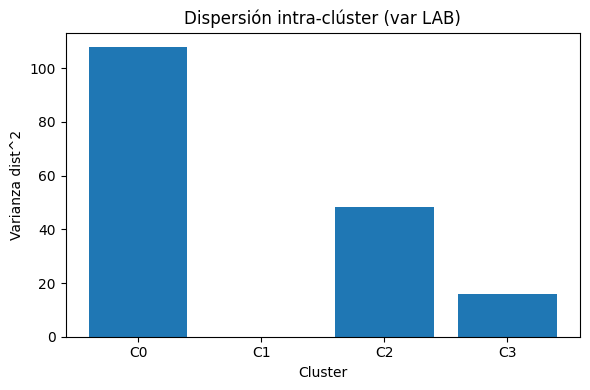

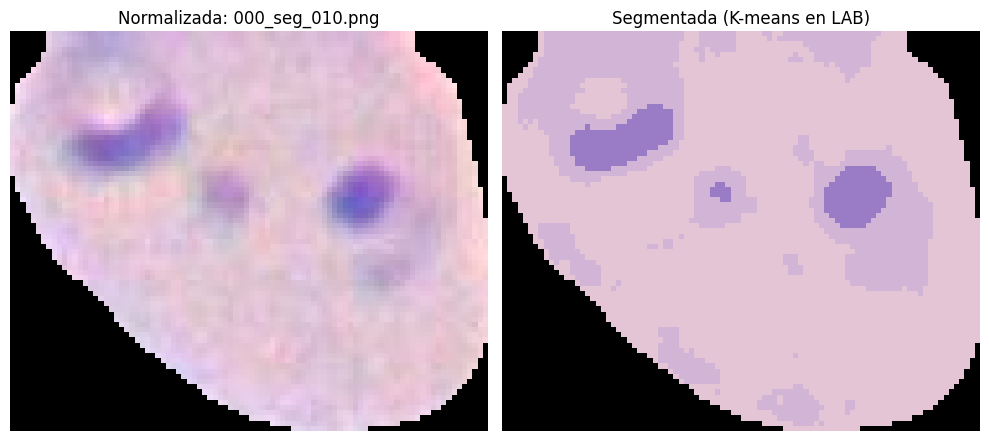

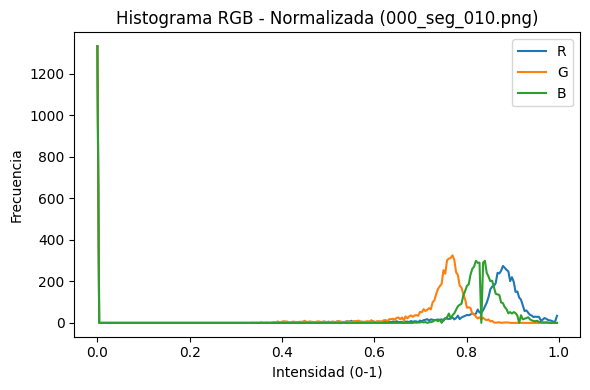

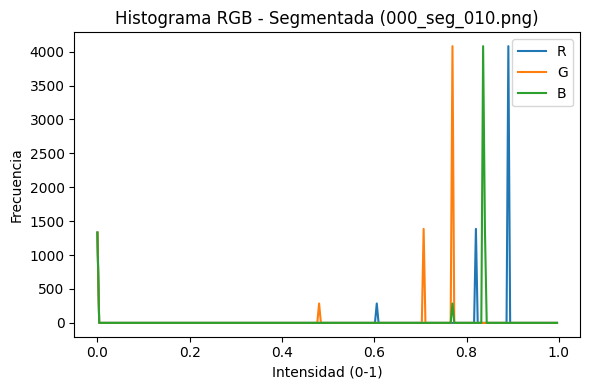

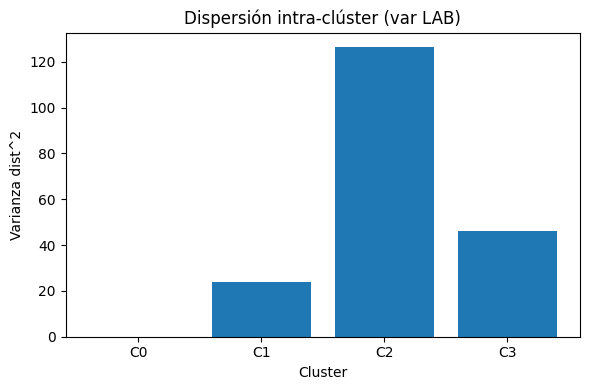

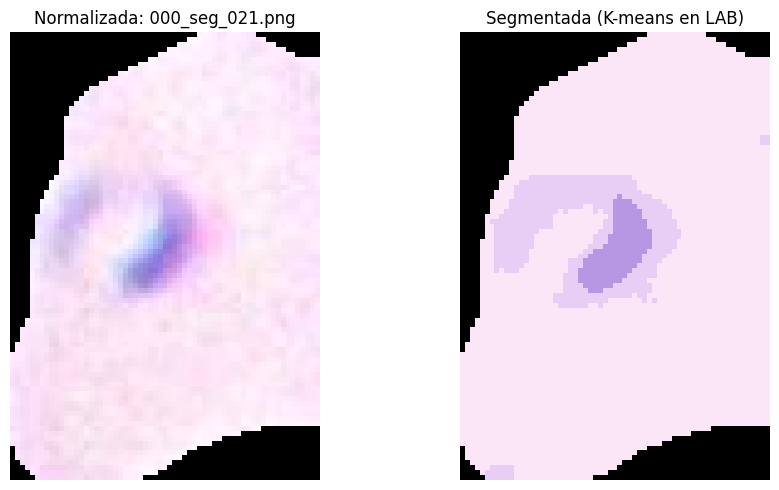

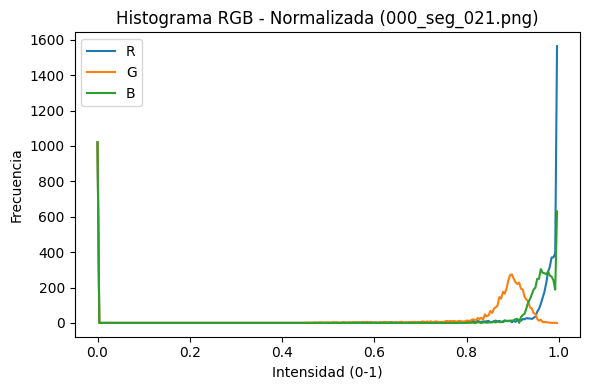

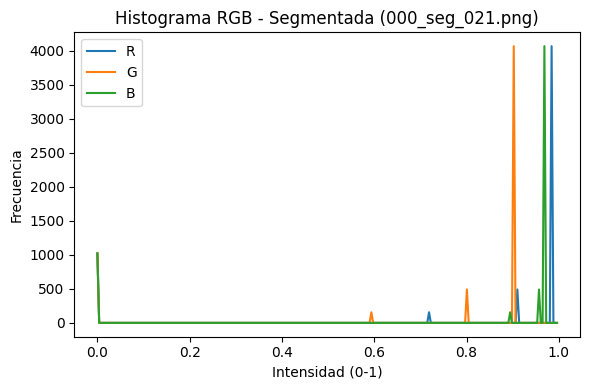

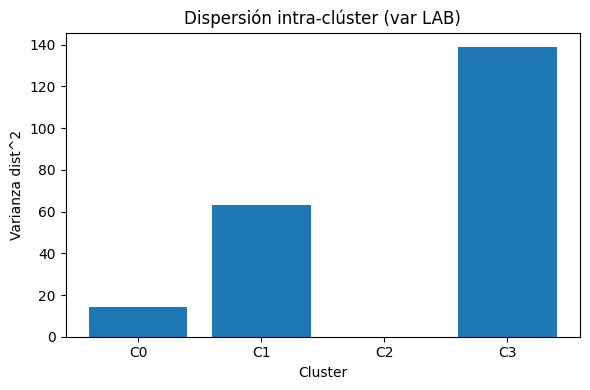

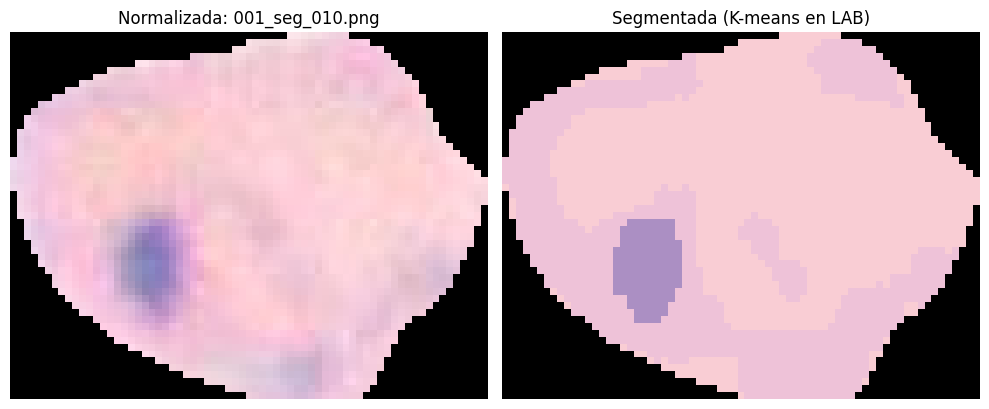

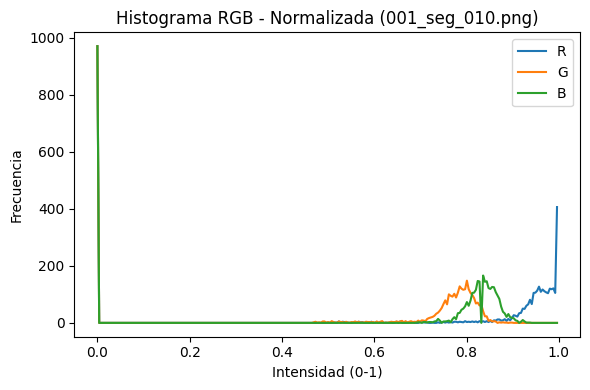

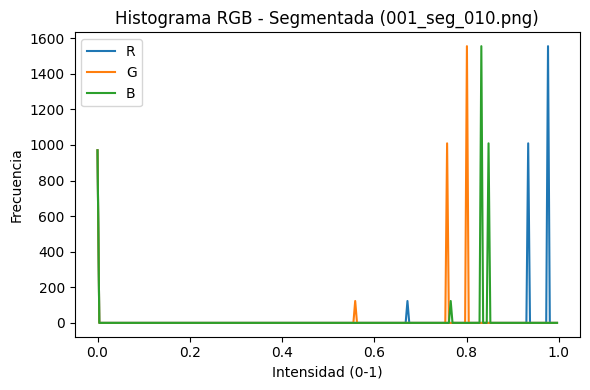

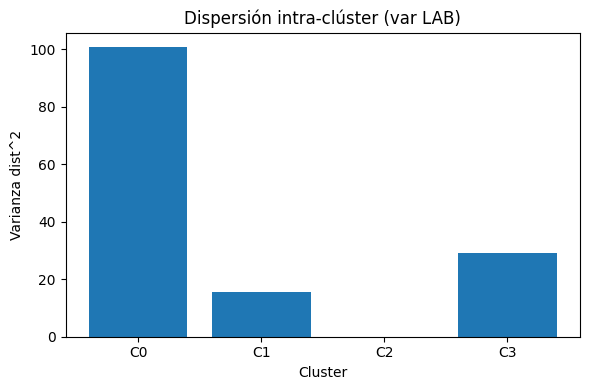

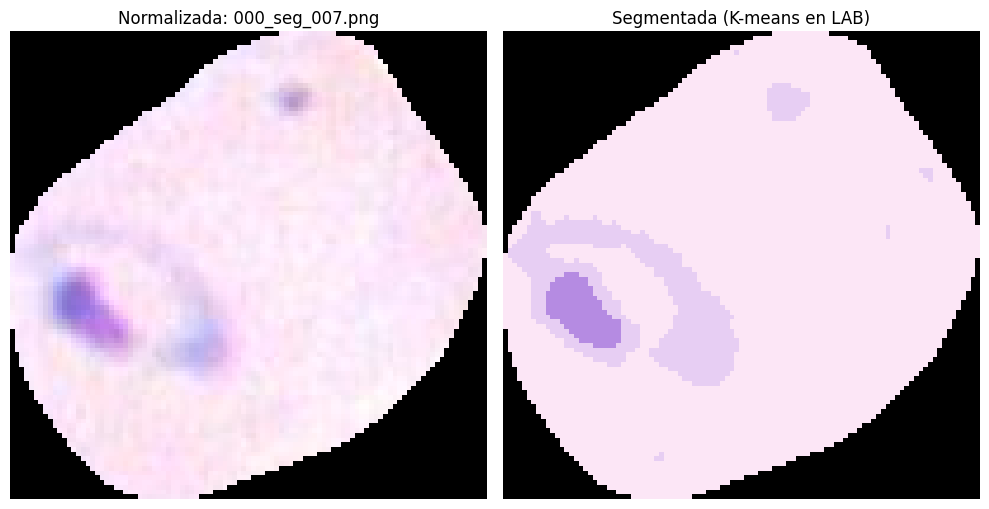

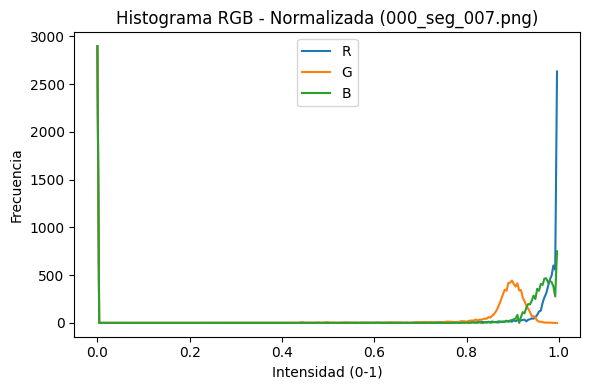

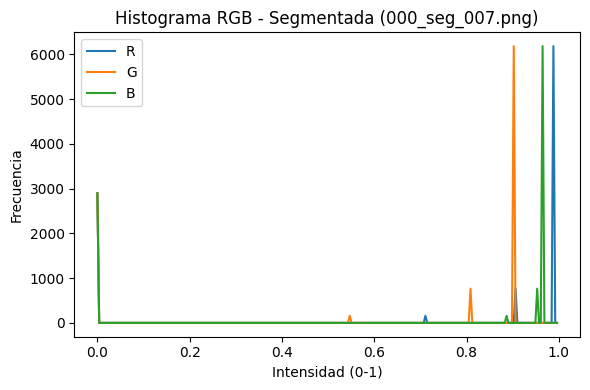

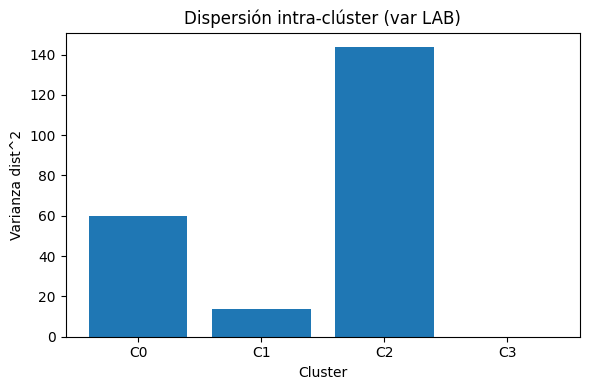

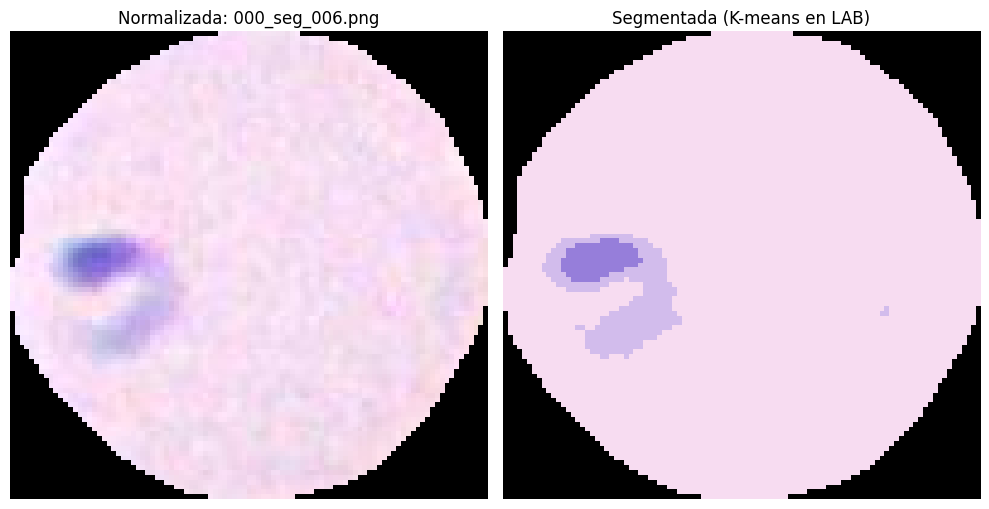

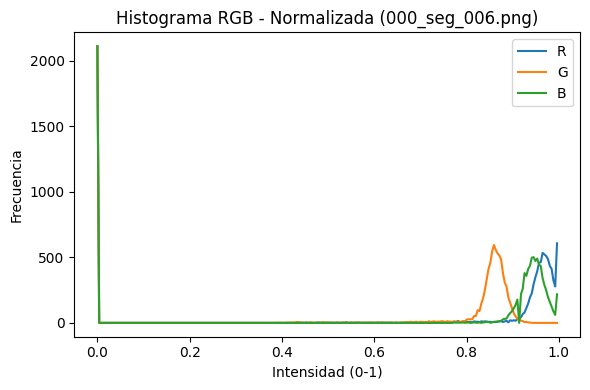

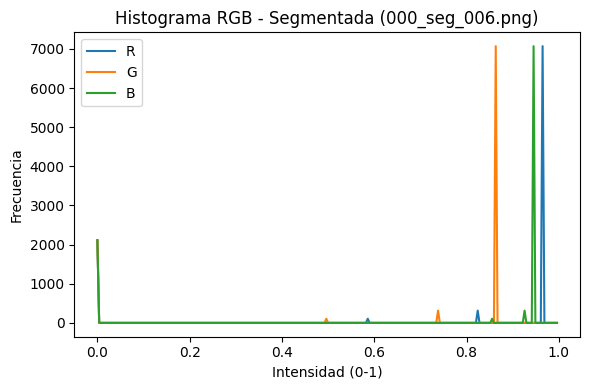

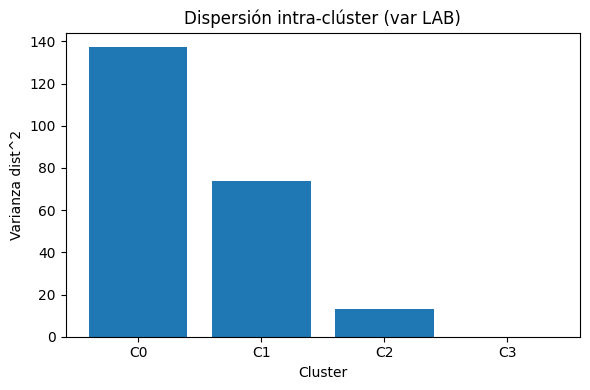

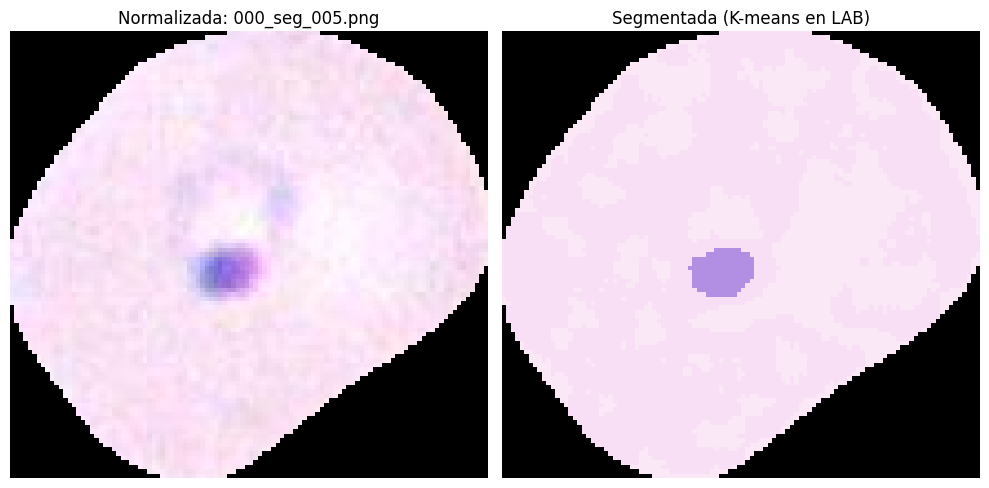

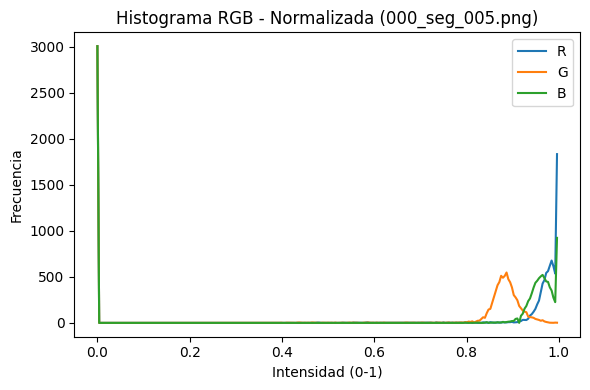

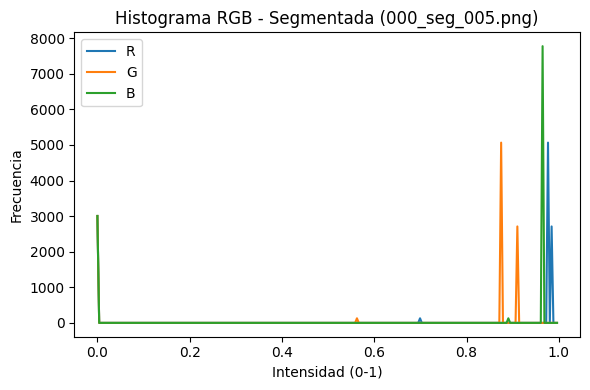

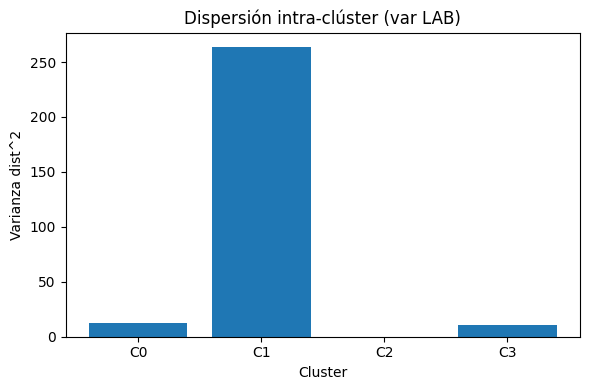

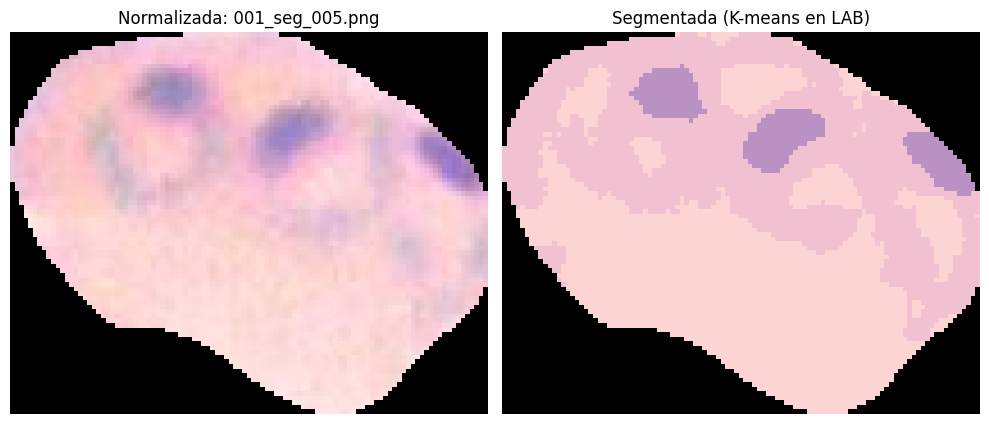

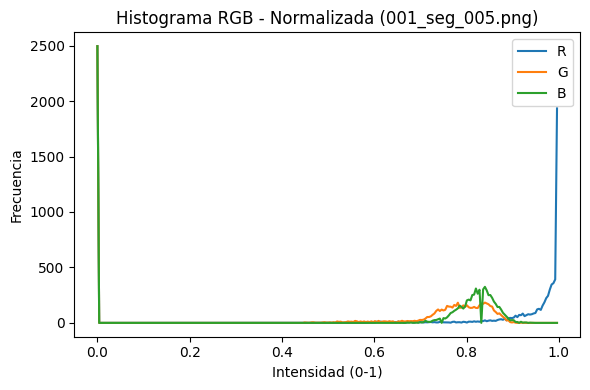

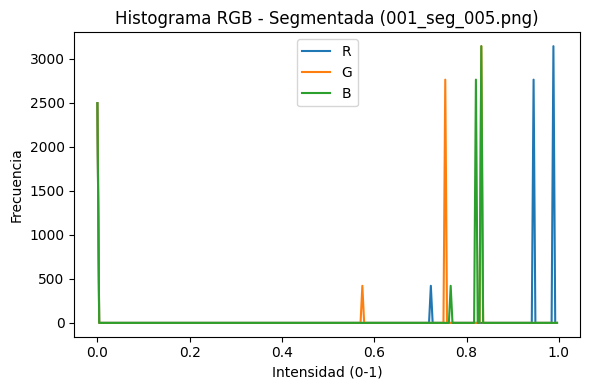

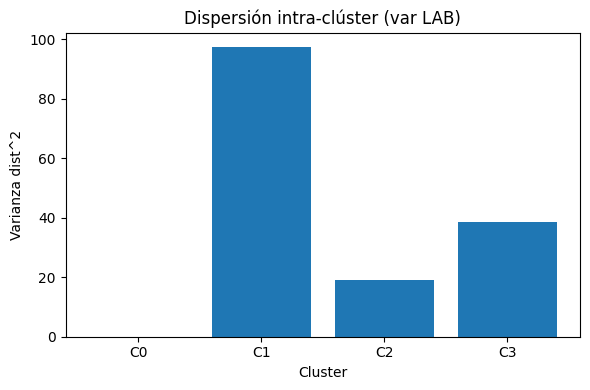

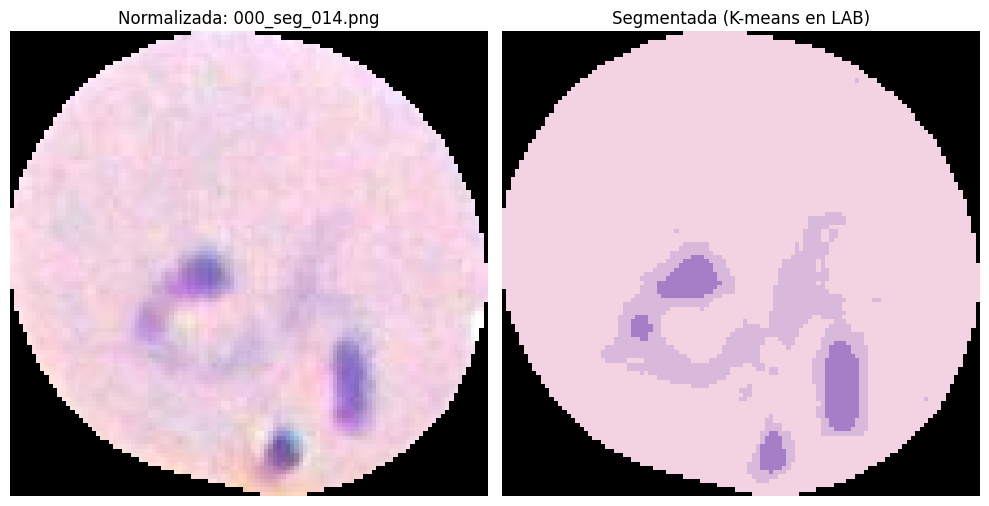

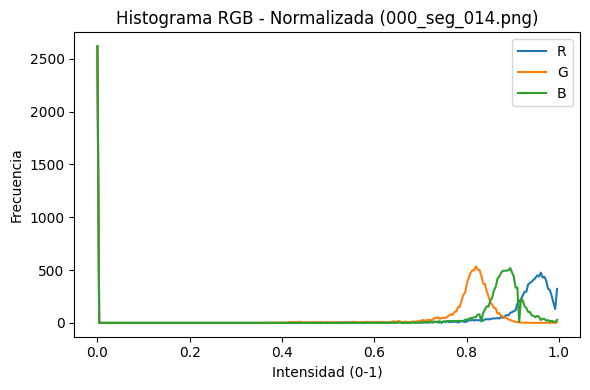

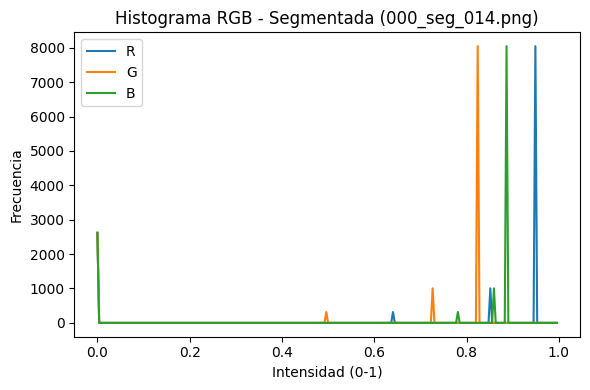

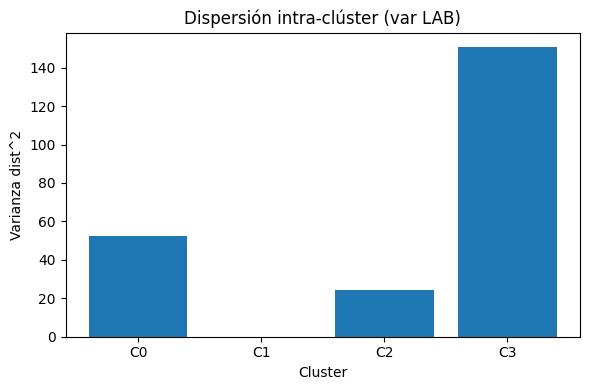

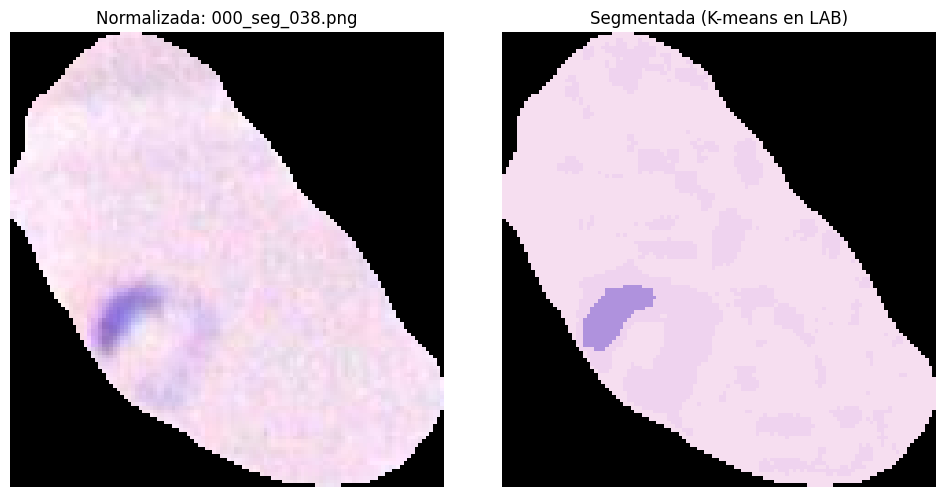

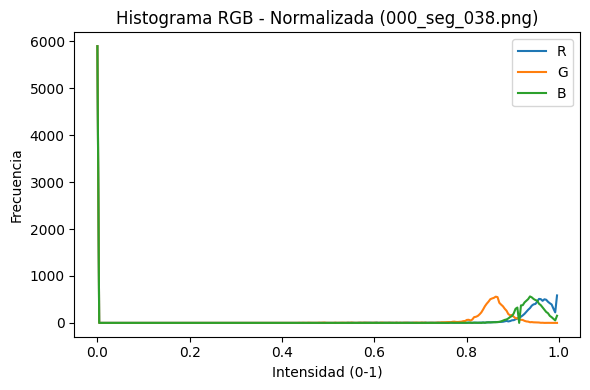

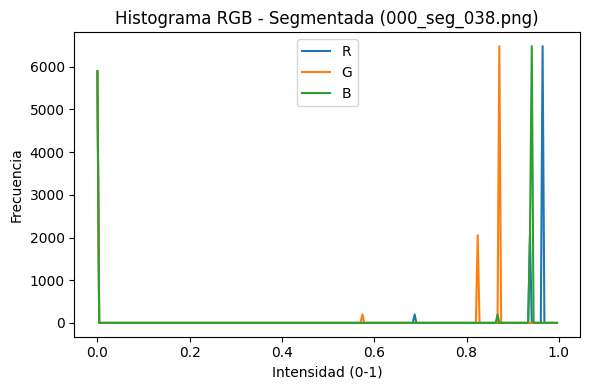

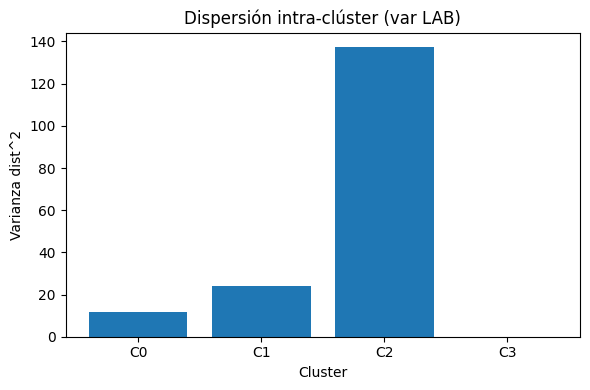

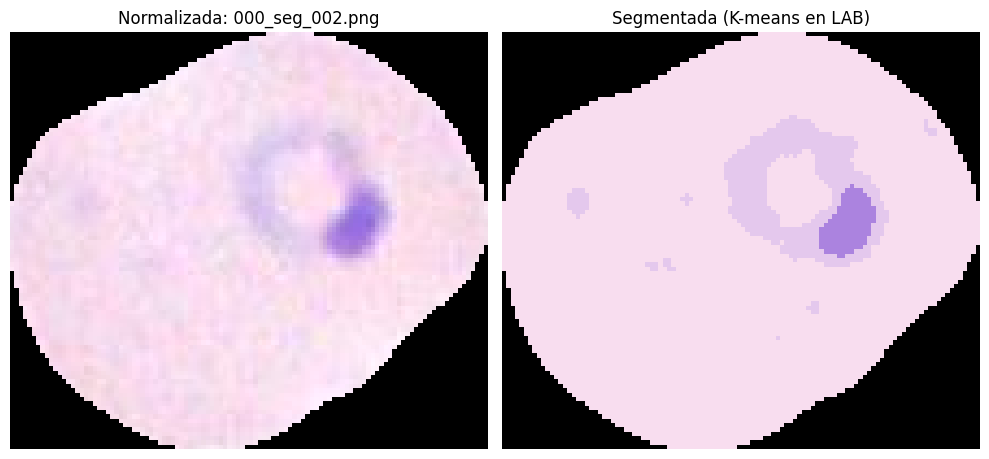

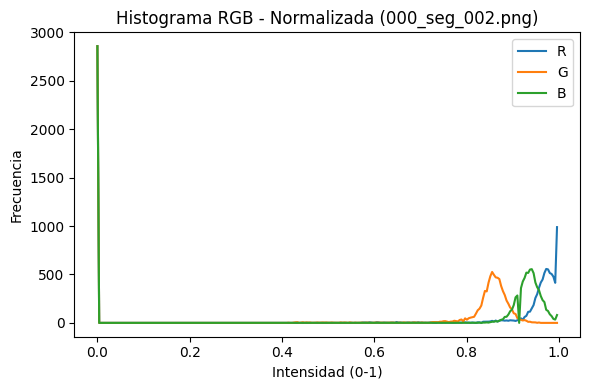

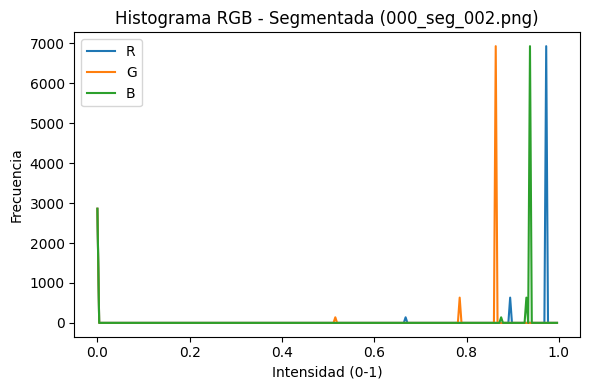

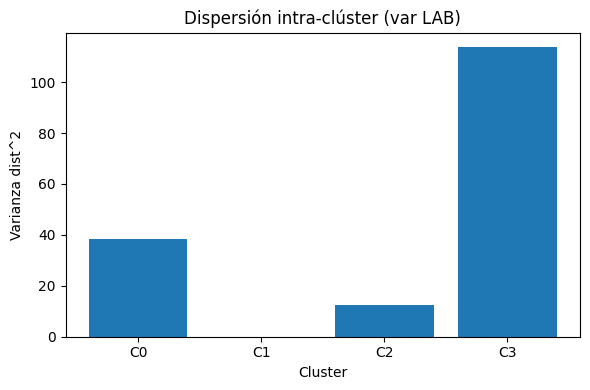


Resultados guardados en: img/resumen_clusters.csv
            imagen  cluster  pixeles  dispersion_var_LAB  centroid_L  \
0  000_seg_016.png        0      449          115.981125   71.674759   
1  000_seg_016.png        1     3312           20.277367   86.040909   
2  000_seg_016.png        2     3378           10.985467   88.119385   
3  000_seg_016.png        3     3249            0.000000    0.000000   
4  001_seg_006.png        0     2461            0.000000    0.000000   

   centroid_A  centroid_B  
0   26.390238  -22.675726  
1   16.376062   -8.486735  
2   13.308621   -3.615230  
3    0.000000    0.000000  
4    0.000000    0.000000  


In [6]:
from pathlib import Path
import numpy as np
import cv2
from skimage import color as skcolor, img_as_ubyte
import matplotlib.pyplot as plt
import pandas as pd

# =============== Utilidades ===============

def read_rgb_float01(path: str):
    """cv2.imread -> RGB float32 en [0,1]"""
    arr = cv2.imread(path, cv2.IMREAD_COLOR)
    if arr is None:
        raise FileNotFoundError(f"No se puede leer: {path}")
    arr = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)
    return (arr.astype(np.float32) / 255.0)

def normalize_img(img: np.ndarray, rimg: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    """Normaliza por imagen de referencia, resultado en [0,1]."""
    norm = img / (rimg + eps)
    norm = np.nan_to_num(norm, nan=0.0, posinf=0.0, neginf=0.0)
    return np.clip(norm, 0.0, 1.0).astype(np.float32)

def kmeans_lab_segments(rgb_float: np.ndarray, K: int = 4, max_iter: int = 60, attempts: int = 20):
    """
    RGB[0,1] -> LAB, k-means en LAB.
    Devuelve: labels (N,), centers (K,3) en LAB, segmented_lab (H,W,3) en LAB, lab_image (H,W,3).
    """
    lab = skcolor.rgb2lab(rgb_float)               # float64
    h, w, _ = lab.shape
    samples = lab.reshape((-1, 3)).astype(np.float32)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, max_iter, 1.0)
    compactness, labels, centers = cv2.kmeans(
        samples, K, None, criteria, attempts, cv2.KMEANS_RANDOM_CENTERS
    )
    labels = labels.flatten()
    segmented_lab = centers[labels].reshape((h, w, 3))
    return labels, centers, segmented_lab, lab

def plot_rgb_histogram(img, title="Histograma RGB"):
    """Histogramas de los 3 canales RGB (imagen en [0,1])."""
    plt.figure(figsize=(6,4))
    for i, name in enumerate(("R","G","B")):
        hist, bins = np.histogram(img[:,:,i].ravel(), bins=256, range=(0,1))
        plt.plot(bins[:-1], hist, label=name)
    plt.title(title)
    plt.xlabel("Intensidad (0-1)")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.tight_layout()
    plt.show()

def cluster_dispersion(lab_image, labels, centers):
    """
    Varianza intra-clúster por centroide en LAB:
    sigma_k^2 = mean(||x_i - mu_k||^2) para i en cluster k.
    """
    X = lab_image.reshape((-1,3))
    dispersions = []
    for k in range(centers.shape[0]):
        pts = X[labels == k]
        if pts.shape[0] == 0:
            dispersions.append(np.nan)
        else:
            d2 = np.sum((pts - centers[k])**2, axis=1)
            dispersions.append(float(np.mean(d2)))
    return dispersions

# =============== Configuración ===============
root = "./img"     # cambia si es necesario
K = 4
save_dir = Path(root)
csv_path = Path(root) / "resumen_clusters.csv"

# =============== Buscar pares *_ref.png ===============
pairs = []
for ref_path in Path(root).rglob("*_ref.png"):
    img_path = Path(str(ref_path).replace("_ref.png", ".png"))
    if img_path.exists():
        pairs.append((img_path, ref_path))

print(f"Pares encontrados: {len(pairs)}")
if len(pairs) == 0:
    print("No se encontraron pares. Revisa rutas/formatos.")

# =============== Resultados (pandas) ===============
rows = []

# =============== Proceso por imagen ===============
for (img_path, ref_path) in pairs:
    # 1) Lectura y normalización
    img  = read_rgb_float01(str(img_path))
    rimg = read_rgb_float01(str(ref_path))
    norm_img = normalize_img(img, rimg)

    # 2) K-means en LAB
    labels, centers, seg_lab, lab_img = kmeans_lab_segments(norm_img, K=K)
    seg_rgb = skcolor.lab2rgb(seg_lab)

    # 3) Métricas: conteos + dispersión
    counts = np.bincount(labels, minlength=centers.shape[0]).astype(int).tolist()
    disp = cluster_dispersion(lab_img, labels, centers)

    # 4) Guardar segmentación
    out_path = save_dir / f"{img_path.stem}_seg.png"
    cv2.imwrite(str(out_path), cv2.cvtColor(img_as_ubyte(seg_rgb), cv2.COLOR_RGB2BGR))

    # 5) Guardar filas para DataFrame (incluye centroid_L, centroid_A, centroid_B)
    for k_idx in range(len(counts)):
        rows.append({
            "imagen": img_path.name,
            "cluster": k_idx,
            "pixeles": counts[k_idx],
            "dispersion_var_LAB": disp[k_idx],
            "centroid_L": float(centers[k_idx,0]),
            "centroid_A": float(centers[k_idx,1]),
            "centroid_B": float(centers[k_idx,2]),
        })

    # 6) Visualizaciones
    # Normalizada vs Segmentada
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(norm_img)
    plt.title(f"Normalizada: {img_path.name}")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(seg_rgb)
    plt.title("Segmentada (K-means en LAB)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Histogramas RGB
    plot_rgb_histogram(norm_img, f"Histograma RGB - Normalizada ({img_path.name})")
    plot_rgb_histogram(seg_rgb,  f"Histograma RGB - Segmentada ({img_path.name})")

    # Dispersión por clúster
    plt.figure(figsize=(6,4))
    x = np.arange(len(disp))
    plt.bar(x, disp)
    plt.xticks(x, [f"C{k}" for k in range(len(disp))])
    plt.title("Dispersión intra-clúster (var LAB)")
    plt.xlabel("Cluster")
    plt.ylabel("Varianza dist^2")
    plt.tight_layout()
    plt.show()

# =============== DataFrame y exportación ===============
df = pd.DataFrame(rows, columns=[
    "imagen","cluster","pixeles","dispersion_var_LAB",
    "centroid_L","centroid_A","centroid_B"
])
df.to_csv(csv_path, index=False)
print(f"\nResultados guardados en: {csv_path}")
print(df.head())


In [7]:
df

imagen  cluster  pixeles  dispersion_var_LAB  centroid_L  \
0    000_seg_016.png        0      449          115.981125   71.674759   
1    000_seg_016.png        1     3312           20.277367   86.040909   
2    000_seg_016.png        2     3378           10.985467   88.119385   
3    000_seg_016.png        3     3249            0.000000    0.000000   
4    001_seg_006.png        0     2461            0.000000    0.000000   
..               ...      ...      ...                 ...         ...   
131  000_seg_038.png        3     5898            0.000000    0.000000   
132  000_seg_002.png        0      633           38.292427   84.154129   
133  000_seg_002.png        1     2858            0.000000    0.000000   
134  000_seg_002.png        2     6929           12.413623   90.837723   
135  000_seg_002.png        3      140          113.681725   62.085567   

     centroid_A  centroid_B  
0     26.390238  -22.675726  
1     16.376062   -8.486735  
2     13.308621   -3.615230  
3      0.000000    0.000000  
4      0.000000    0.000000  
..          ...         ...  
131    0.000000    0.000000  
132   16.489273  -14.709432  
133    0.000000    0.000000  
134   12.648863   -5.448876  
135   33.328453  -41.479904  

[136 rows x 7 columns]

/home/alejandro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/alejandro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/alejandro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/alejandro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a le

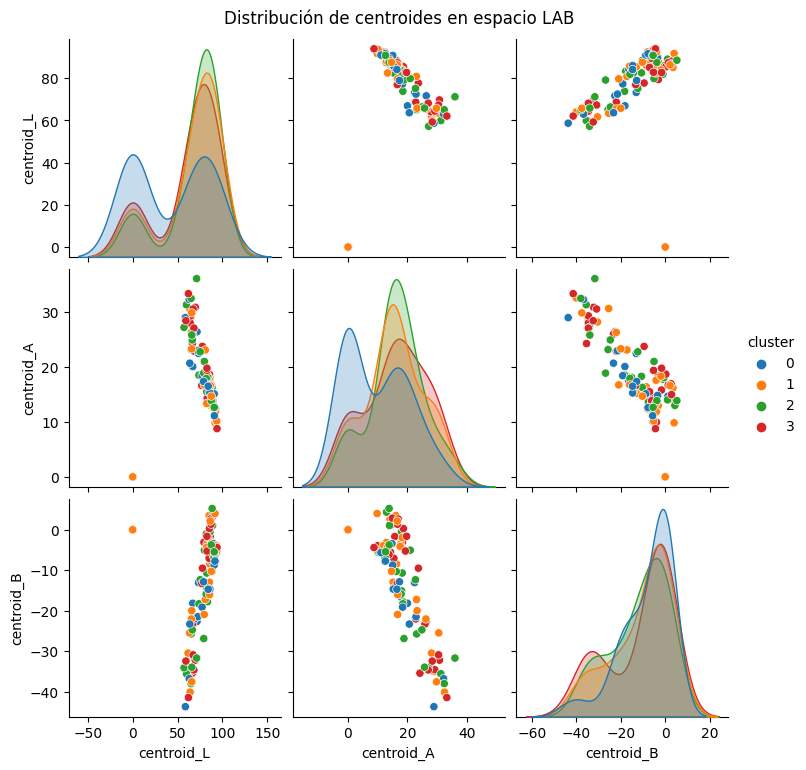

In [8]:
import seaborn as sns

# Suponiendo que df ya existe y tiene las columnas:
# ["imagen","cluster","pixeles","dispersion_var_LAB","centroid_L","centroid_A","centroid_B"]

# Filtramos solo las columnas de los centroides
df_centroids = df[["centroid_L","centroid_A","centroid_B","cluster","imagen"]]

# Usamos pairplot: relaciones entre L, A y B
sns.pairplot(
    df_centroids,
    vars=["centroid_L","centroid_A","centroid_B"],
    hue="cluster",         # color por número de cluster
    palette="tab10",       # paleta de colores
    diag_kind="kde",       # densidad en la diagonal
)

plt.suptitle("Distribución de centroides en espacio LAB", y=1.02)
plt.show()